# Molecular Machine Learning - Studio 7
## Molecular Parametrization and Statistical Methods for Reaction Engineering

**Course:** 06-731 Molecular Machine Learning  
**Instructor:** Professor Gabe Gomes  
---

## Learning Objectives

By the end of this studio session, you will be able to:

1. **Generate and visualize molecular fingerprints** using RDKit's Morgan fingerprinting algorithm
2. **Compute quantum mechanical descriptors** using semi-empirical methods (XTB) via morfeus
3. **Handle conformational ensembles** and apply Boltzmann averaging for QM features
4. **Build baseline ML models** for molecular property prediction using fingerprints
5. **Interpret linear models** through feature importance analysis and bit visualization
6. **Predict reaction outcomes** using concatenated molecular representations
7. **Compare ML methods** (Linear Regression, Bayesian Ridge, Random Forest) using proper cross-validation
8. **Assess model stability** through resampling and bootstrap analysis
9. **Apply ML to real chemistry problems**: HOMO-LUMO gaps, stereoselectivity, and reaction rates

**Estimated Completion Time:** 90-120 minutes

---

## Overview

This studio explores two fundamental approaches to molecular parametrization for machine learning:

### 1. Fingerprint-Based Representations
Fingerprints are sparse binary vectors encoding structural features. They've been the workhorse of cheminformatics since the 1980s and remain excellent baseline representations.

### 2. Quantum Mechanical Features
QM-derived descriptors (charges, orbital energies, sterimol parameters) provide physically motivated features but require 3D structures and are computationally expensive.

### 3. Three Real-World Case Studies
- **HOMO-LUMO gaps**: Property prediction for organic electronics
- **N,S-acetal stereoselectivity**: Enantioselective catalysis with chiral phosphoric acids
- **Diels-Alder reaction rates**: Physical organic chemistry meets machine learning

Each case study demonstrates different aspects of molecular ML: from baseline modeling to feature selection to stability analysis.

---

## Setup and Imports

In [16]:
# Import our utilities
from utils import *

---

# Part 1: Parametrization Using Fingerprints

## Introduction to Molecular Fingerprints

Molecular fingerprints encode structural information as fixed-length binary vectors. Originally designed for similarity searching and QSAR (Quantitative Structure-Activity Relationship) modeling, they remain highly relevant in the deep learning era as:

- **Excellent baselines** for benchmarking more complex methods
- **Interpretable features** for linear models
- **Fast to compute** and **memory efficient**

### Morgan (Circular) Fingerprints

Morgan fingerprints (also called ECFP - Extended Connectivity FingerPrints) encode circular neighborhoods around each atom:

- **Radius 0**: Just the atom itself
- **Radius 1**: Atom + immediate neighbors
- **Radius 2**: Atom + neighbors up to 2 bonds away
- And so on...

Each circular substructure is hashed to a bit position in the fingerprint vector.

**Key Parameters:**
- `radius`: How far to extend around each atom (typical: 2-3)
- `nBits`: Length of fingerprint (typical: 1024-2048, up to 4096)

Let's explore this with **ibuprofen**, a common anti-inflammatory drug:

---

In [17]:
smiles = "CC(C)Cc1ccc(cc1)[C@@H](C)C(=O)O"  # Ibuprofen SMILES
ade_ibuprofen = ade.Molecule(smiles=smiles, name="ibuprofen")
ade_ibuprofen.optimise(method=ade.methods.XTB())
rdkit_ibuprofen = Chem.MolFromSmiles(smiles)
MolTo3DView("ibuprofen_optimised_xtb.xyz")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Generating Morgan Fingerprints

Now let's generate a Morgan fingerprint with radius=2 and 2048 bits:

In [18]:
fp = AllChem.GetMorganFingerprintAsBitVect(rdkit_ibuprofen, 
                                           radius=2, 
                                           nBits=2048)

[09:11:18] DEPRECATION WARNING: please use MorganGenerator


### Fingerprint Sparsity

One of the most important characteristics of fingerprints is their **sparsity** - most bits are zero. Let's examine which bits are "on" (set to 1):

In [19]:
fp_array = np.array(fp)
non_zero_bits = fp_array.nonzero()[0]
print("Number of non-zero bits:", len(non_zero_bits))
non_zero_bits

Number of non-zero bits: 25


array([   1,   79,   80,  283,  310,  389,  650,  807,  854,  857,  900,
        921,  955, 1057, 1146, 1257, 1365, 1380, 1750, 1754, 1844, 1847,
       1853, 1873, 1917])

**Only ~25 out of 2048 bits are set!** This extreme sparsity (~1.2% density) is typical for molecular fingerprints.

### Fingerprint Folding

Because fingerprints are so sparse, we can often **fold** them to shorter lengths:
- 4096 → 2048 → 1024 → 512

Folding combines bits using OR operations (e.g., bits 0 and 1024 fold into bit 0 of the 1024-bit version).

**Trade-off:**
- ✅ Faster ML training and inference
- ✅ Lower memory usage
- ❌ Bit collisions (information loss)

The severity of information loss depends on your dataset and application. You'll explore this in the exercises!

---

## Visualization of Fingerprints

A fingerprint bit corresponds to a specific structural fragment, but which one? RDKit lets us visualize exactly what each bit encodes.

### Capturing Bit Information

We pass an empty dictionary `bitInfo` to capture which atoms contribute to each bit:

In [20]:
bit_info = {}
fp = AllChem.GetMorganFingerprintAsBitVect(rdkit_ibuprofen, 
                                           radius=2, 
                                           nBits=2048, 
                                           bitInfo=bit_info)

[09:11:18] DEPRECATION WARNING: please use MorganGenerator


### Drawing Morgan Bits

Now we can visualize all the structural fragments that contribute to this fingerprint:

**Color coding:**
- 🔵 **Blue**: Central atom
- ⚫ **Black bonds**: Bonds included in the radius
- 🟢 **Green highlighting**: Atoms within the circular neighborhood

The number of black bonds indicates the radius (0, 1, or 2 for our radius=2 fingerprint).

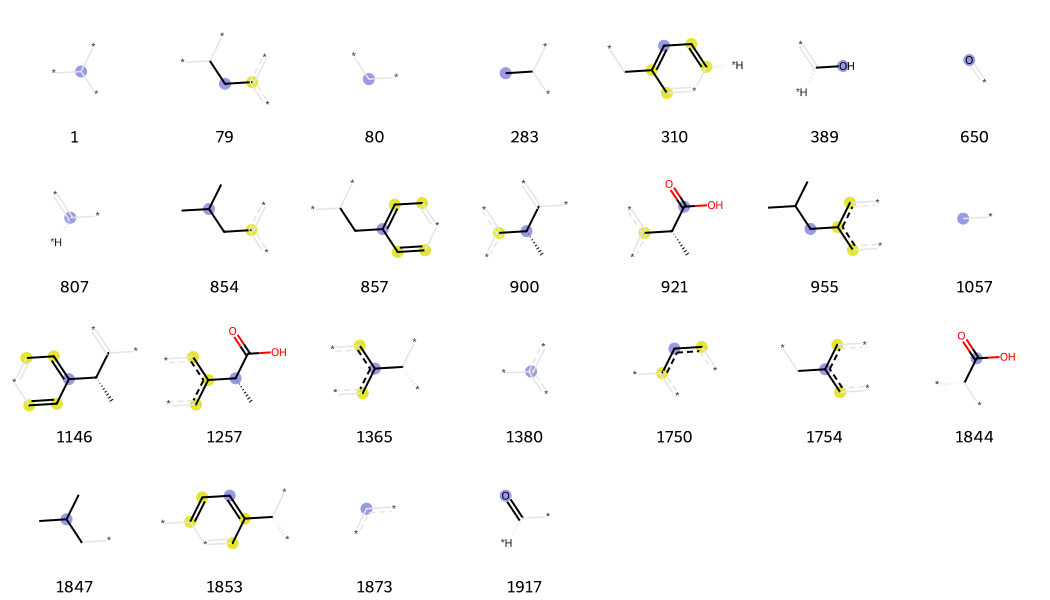

In [21]:
tpls = [(rdkit_ibuprofen, x, bit_info) for x in fp.GetOnBits()]
legends = [str(x) for x in fp.GetOnBits()]
Chem.Draw.DrawMorganBits(tpls, 
                         molsPerRow=7, 
                         legends=legends, 
                         useSVG=True)

### Interpreting Fingerprint Bits

Each image shows:
1. The **bit number** (legend)
2. The **circular substructure** that hashes to that bit
3. The **radius** of the substructure (count the bond layers)

**Notice:**
- Simple features (CH₃ groups) at radius 0-1
- More complex features (aromatic patterns) at radius 2
- Some bits capture very specific structural motifs

Later, we'll use this visualization technique to **interpret machine learning models** by identifying which structural features drive predictions!

---

---

# Part 2: Parametrization with Quantum Mechanical Features

## Introduction to QM Descriptors

Quantum mechanical (QM) calculations provide physically motivated descriptors:
- **Atomic charges** (electrostatics)
- **Orbital energies** (HOMO, LUMO)
- **Sterimol parameters** (steric effects)
- **NBO charges** (natural bond orbitals)

### Trade-offs of QM Features

**Advantages:**
- ✅ Physically interpretable
- ✅ Can capture subtle electronic effects
- ✅ Expert knowledge encoded

**Disadvantages:**
- ❌ Computationally expensive
- ❌ Require 3D structures (conformers)
- ❌ Manual feature selection needed
- ❌ Conformational dependence

### Semi-Empirical Methods

To reduce computational cost, we use **semi-empirical QM** methods like **XTB** (extended tight-binding):
- Much faster than DFT (~1000x)
- Reasonable accuracy for many properties
- Systematic errors may cancel in ML models

We'll use the **morfeus** library to interface with XTB.

---

In [22]:
from morfeus.conformer import ConformerEnsemble
from morfeus import XTB

## Generating Conformer Ensembles

QM features require 3D coordinates. Let's generate a conformer ensemble for **diclofenac** (a common NSAID):

<div style="background-color: #e3f2fd; padding: 15px; border-radius: 5px; border-left: 4px solid #2196f3;">
    <strong>💡 Key Concept:</strong> A conformer ensemble captures the molecule's flexibility by sampling different 3D arrangements.
</div>

In [23]:
# Generate a conformer ensemble for diclofenac
smiles = "C1=CC=C(C(=C1)CC(=O)O)NC2=C(C=CC=C2Cl)Cl"  # SMILES for diclofenac
ade_diclofenac = ade.Molecule(smiles=smiles, name="diclofenac")
ade_diclofenac.optimise(method=ade.methods.XTB())
rdkit_diclofenac = Chem.MolFromSmiles(smiles)
MolTo3DView("diclofenac_optimised_xtb.xyz")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [24]:
# Create conformer ensemble with MMFF94
ce = ConformerEnsemble.from_rdkit(smiles, optimize="MMFF94")
ce.prune_rmsd()  # Prune out similar structures
ce.sort()        # Sort by energy
print("Number of conformers:", len(ce))

Number of conformers: 20


## Computing Atomic Charges with XTB

Now let's calculate atomic charges for the **lowest energy conformer** using XTB:

In [25]:
# Calculate properties for the lowest energy conformer
elements = ce.elements
coordinates = ce[0].coordinates
xtb = XTB(elements, coordinates)
charges = list(xtb.get_charges().values())
print(charges)

[np.float64(-0.03585586068952891), np.float64(-0.030546568486197558), np.float64(-0.04388231518053297), np.float64(0.07587396110468625), np.float64(-3.920665098679221e-05), np.float64(-0.03754828194218602), np.float64(-0.09128771852289472), np.float64(0.35902775823324995), np.float64(-0.4207965162639416), np.float64(-0.3772946389844212), np.float64(-0.19417004686410166), np.float64(0.05811693679401417), np.float64(0.07146715350301786), np.float64(-0.044343826554788086), np.float64(-0.038015674448738664), np.float64(-0.04553164291296667), np.float64(0.08001418077879702), np.float64(-0.16221873253785798), np.float64(-0.1592917466765926), np.float64(0.03498005458795152), np.float64(0.03648013573121939), np.float64(0.03419239943865649), np.float64(0.03536529815617375), np.float64(0.09447371828135483), np.float64(0.07919647739778819), np.float64(0.3368466453857836), np.float64(0.2055538782549493), np.float64(0.061565214945056755), np.float64(0.054709336591112864), np.float64(0.0629596275319

## Visualizing Atomic Charges

RDKit's `SimilarityMaps` module can visualize atomic properties:
- 🔴 **Red**: Negative charge (electron-rich)
- 🟢 **Green**: Positive charge (electron-poor)
- **Intensity**: Magnitude of charge

Number of heavy atoms in rdkit_diclofenac: 19
Number of charges from XTB: 30


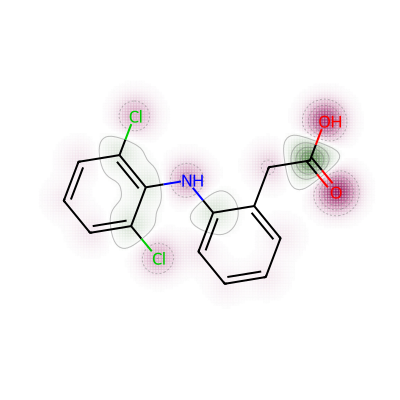

In [26]:
# from rdkit.Chem.Draw import SimilarityMaps
# sim_map = SimilarityMaps.GetSimilarityMapFromWeights#(rdkit_diclofenac, 
#                                                      charges)



from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import Draw

# The rdkit_diclofenac molecule from SMILES doesn't have explicit hydrogens
# But the charges list from XTB includes ALL atoms (heavy + hydrogens)
# We need to match them by only using charges for heavy atoms

# Count heavy atoms in the molecule
num_heavy_atoms = rdkit_diclofenac.GetNumAtoms()
print(f"Number of heavy atoms in rdkit_diclofenac: {num_heavy_atoms}")
print(f"Number of charges from XTB: {len(charges)}")

# Use only the first num_heavy_atoms charges (XTB outputs heavy atoms first, then hydrogens)
charges_heavy = charges[:num_heavy_atoms]

# Create a drawing object - use MolDraw2DSVG for SVG output
d = Draw.MolDraw2DSVG(400, 400)

# Generate the similarity map with the draw2d parameter
sim_map = SimilarityMaps.GetSimilarityMapFromWeights(rdkit_diclofenac, 
                                                     charges_heavy,
                                                     draw2d=d)
# Finish the drawing
d.FinishDrawing()

# Display the image
from IPython.display import SVG, display
display(SVG(d.GetDrawingText()))

---

## The Conformational Dependence Problem

QM descriptors depend on 3D geometry, but molecules are flexible! How do we handle this?

### Common Strategies:

1. **Ignore it** 😬 (use any conformer, hope for the best)
2. **Lowest energy conformer** 🎯 (assume Boltzmann distribution heavily weights this)
3. **Boltzmann averaging** ⚖️ (statistically rigorous weighted average)
4. **Min/max sampling** 📊 (capture range of values)
5. **All conformers** 🎲 (data augmentation)

Let's explore the **variation across conformers** and implement **Boltzmann averaging**.

<div style="background-color: #fff3e0; padding: 15px; border-radius: 5px; border-left: 4px solid #ff9800;">
    <strong>⚠️ Note:</strong> The following calculation takes ~1 minute. This illustrates a key disadvantage of QM descriptors - computational cost!
</div>

In [27]:
for conformer in ce:
    xtb = XTB(ce.elements, conformer.coordinates)
    charges = list(xtb.get_charges().values())
    conformer.properties["charges"] = charges

## Visualizing Charge Variation

Let's plot how atomic charges vary across the conformer ensemble using a box plot:

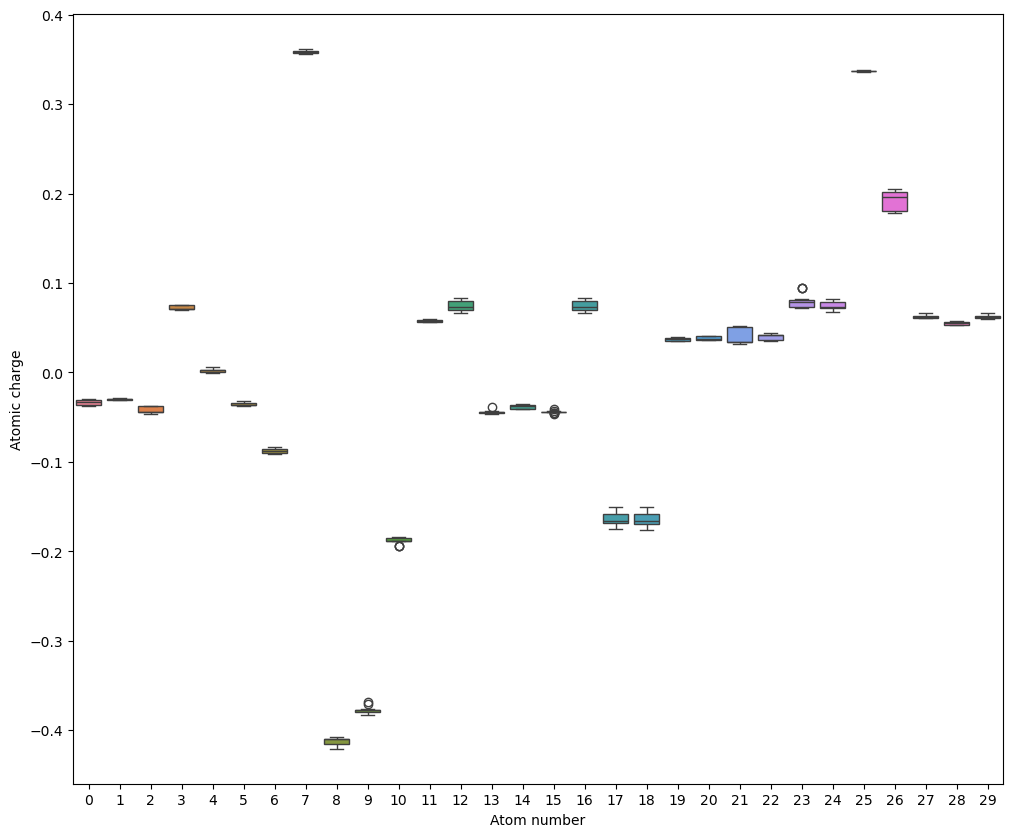

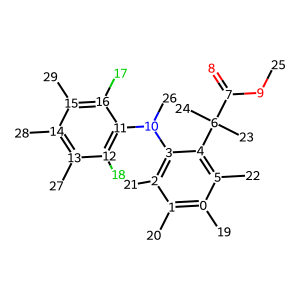

In [28]:
# Make dataframe of data to display easily with seaborn
df = pd.DataFrame(ce.get_properties()["charges"])

plt.figure(figsize=(12, 10))
sns.boxplot(data=df)
plt.xlabel("Atom number")
plt.ylabel("Atomic charge")
plt.show()

# Display mol object without 3D info and with atom numbers
disp_mol = Chem.Mol(ce.mol)
disp_mol.RemoveAllConformers()
for atom in disp_mol.GetAtoms():
    atom.SetProp('atomLabel', str(atom.GetIdx()))
Chem.Draw.MolToImage(disp_mol)

<div style="background-color: #f3e5f5; padding: 15px; border-radius: 5px; border-left: 4px solid #9c27b0;">
    <strong>🤔 Think About It:</strong>
    <p>What is the cause of the high variance of the charge on atom 26?</p>
    <p><em>Hint: Look at the 2D structure. What functional group is atom 26? How flexible is it?</em></p>
</div>

---

## Boltzmann Averaging

One rigorous way to condense conformer information is **Boltzmann averaging** from statistical thermodynamics.

Each conformer contributes to the average in proportion to its **Boltzmann weight**:

$$P_{\text{avg}} = \frac{1}{N}\sum_{i=1}^{N}{P_i \cdot w_i}$$

Where the weights are:

$$w_{i}=\frac {e^{-{\varepsilon }_{i}/(k_BT)}}{\sum _{j=1}^{M}{e^{-{\varepsilon }_{j}/(k_BT)}}}$$

**Physical interpretation:**
- Lower energy conformers → higher weight → contribute more
- Higher energy conformers → lower weight → contribute less
- At room temperature (298 K), ~99% of weight often comes from the lowest 2-3 conformers

Morfeus implements this for us:

In [29]:
ce.boltzmann_statistic("charges")

array([-3.61207827e-02, -3.06140144e-02, -4.44218340e-02,  7.49398322e-02,
       -1.74163752e-04, -3.72887832e-02, -9.10658323e-02,  3.58550629e-01,
       -4.18669680e-01, -3.77786401e-01, -1.92540073e-01,  5.81385994e-02,
        7.72488209e-02, -4.49567683e-02, -3.75867653e-02, -4.46354024e-02,
        7.49494074e-02, -1.60089784e-01, -1.60903483e-01,  3.50501654e-02,
        3.63858391e-02,  3.38501489e-02,  3.66153696e-02,  9.09123443e-02,
        7.84655088e-02,  3.36766544e-01,  2.04553701e-01,  6.27893899e-02,
        5.52187975e-02,  6.24186698e-02])

### Summary: QM Features

**What we learned:**
1. ✅ QM features require 3D structures (conformers)
2. ✅ Semi-empirical methods (XTB) make QM tractable for ML
3. ✅ Conformational flexibility affects feature values
4. ✅ Boltzmann averaging provides rigorous statistical treatment
5. ⚠️ Even semi-empirical QM is much slower than fingerprints

**When to use QM features:**
- Small to medium datasets where computation time is acceptable
- Problems where electronic effects dominate (e.g., reactivity, pKa)
- When physical interpretability is important
- As complement to fingerprints (hybrid approaches)

---

---

# Part 3: Case Study 1 - HOMO-LUMO Gaps

## Introduction

Before tackling reaction prediction, let's start with a simpler problem: predicting **HOMO-LUMO gaps** for organic molecules.

### What is the HOMO-LUMO gap?

The **HOMO-LUMO gap** (also called the **energy gap** or **band gap**) is the energy difference between:
- **HOMO**: Highest Occupied Molecular Orbital
- **LUMO**: Lowest Unoccupied Molecular Orbital

### Why does it matter?

The HOMO-LUMO gap determines key properties of organic electronics:
- **Optical properties** (absorption, emission wavelengths)
- **Conductivity** (smaller gap → better conductor)
- **Chemical stability** (larger gap → more stable)

**Applications:**
- Organic LEDs (OLEDs)
- Organic photovoltaics (solar cells)
- Organic field-effect transistors (OFETs)

### The Dataset

We'll use data from [Glorius et al., Chem 2020](https://doi.org/10.1016/j.chempr.2020.02.017):
- 2,904 organic molecules
- HOMO-LUMO gaps computed with DFT
- Diverse structural space

**Goal:** Build a fast ML model that predicts HOMO-LUMO gaps from SMILES using fingerprints.

---

## Data Preparation

The data is provided in a machine-readable Excel format. Let's load it and explore:

<div style="background-color: #e8f5e9; padding: 15px; border-radius: 5px; border-left: 4px solid #4caf50;">
    <strong>📝 Note:</strong> You might see a warning when reading the Excel file - this is normal and can be safely ignored.
</div>

Index(['SMILES', 'Energygap'], dtype='object')


<Axes: ylabel='Frequency'>

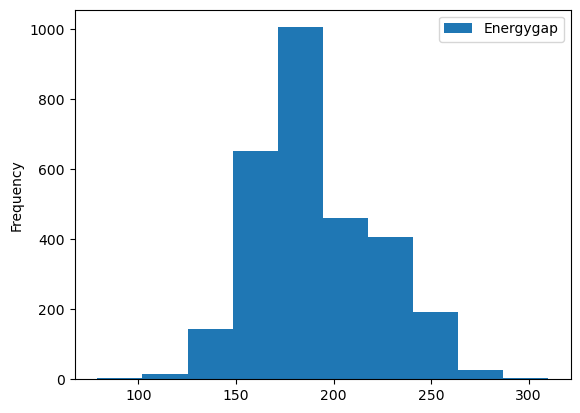

In [31]:
df = pd.read_excel("homo-lumo.xlsx", sheet_name=0)
print(df.columns)
df.plot.hist(y="Energygap")

In [32]:
df.shape

(2904, 2)

### Data Distribution

The HOMO-LUMO gaps are distributed between ~100-300 kcal/mol (4.3-13.0 eV).

**Observations:**
- Roughly normal distribution (good for regression!)
- No extreme outliers
- Sufficient range to test model extrapolation

Now let's generate **Morgan fingerprints** as our molecular representation:

In [33]:
fps = []
mols = []
# Loop over all datapoints and generate fingerprints from the SMILES
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row["SMILES"])
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
    fps.append(fp)
    mols.append(mol)
X = np.vstack(fps)  # Stack all fps into a NumPy array

[09:12:22] DEPRECATION WARNING: please use MorganGenerator
[09:12:22] DEPRECATION WARNING: please use MorganGenerator
[09:12:22] DEPRECATION WARNING: please use MorganGenerator
[09:12:22] DEPRECATION WARNING: please use MorganGenerator
[09:12:22] DEPRECATION WARNING: please use MorganGenerator
[09:12:22] DEPRECATION WARNING: please use MorganGenerator
[09:12:22] DEPRECATION WARNING: please use MorganGenerator
[09:12:22] DEPRECATION WARNING: please use MorganGenerator
[09:12:22] DEPRECATION WARNING: please use MorganGenerator
[09:12:22] DEPRECATION WARNING: please use MorganGenerator
[09:12:22] DEPRECATION WARNING: please use MorganGenerator
[09:12:22] DEPRECATION WARNING: please use MorganGenerator
[09:12:22] DEPRECATION WARNING: please use MorganGenerator
[09:12:22] DEPRECATION WARNING: please use MorganGenerator
[09:12:22] DEPRECATION WARNING: please use MorganGenerator
[09:12:22] DEPRECATION WARNING: please use MorganGenerator
[09:12:22] DEPRECATION WARNING: please use MorganGenerat

In [34]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

**Feature matrix shape:** 2904 molecules × 1024 bits

We're using **1024-bit fingerprints** (smaller than the 2048 we used earlier) to:
- Speed up model training
- Reduce memory usage
- Test whether we lose important information (spoiler: usually we don't!)

---

## Machine Learning with Bayesian Ridge Regression

### Why Bayesian Ridge Regression (BRR)?

BRR is a **regularized linear model** that:
- ✅ Handles high-dimensional sparse data well (perfect for fingerprints!)
- ✅ Provides uncertainty estimates (prediction intervals)
- ✅ Requires no hyperparameter tuning (automatic regularization)
- ✅ Is interpretable (linear coefficients)
- ✅ Trains quickly

**Comparison to other methods:**
- vs. **Linear Regression**: BRR adds regularization → prevents overfitting
- vs. **Ridge/Lasso**: BRR automatically tunes regularization strength
- vs. **Random Forest**: BRR is faster and more interpretable (but less expressive)

Let's build our model:

In [35]:
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [36]:
y = df["Energygap"]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True, 
                                                    train_size=0.8, 
                                                    random_state=42)

In [38]:
br = BayesianRidge()
br.fit(X_train, y_train)

BayesianRidge()

In [39]:
y_test_pred = br.predict(X_test)
mean_absolute_error(y_test, y_test_pred)
y_train_pred = br.predict(X_train)

## Model Performance

Our simple fingerprint + BRR model achieves:
- **MAE ≈ 10.4 kcal/mol** (0.45 eV)

**Context:**
- Glorius et al.'s Random Forest with complex features: **6.3 kcal/mol**
- Our simple model captures ~60% of their performance with much simpler features!

Let's visualize the predictions:

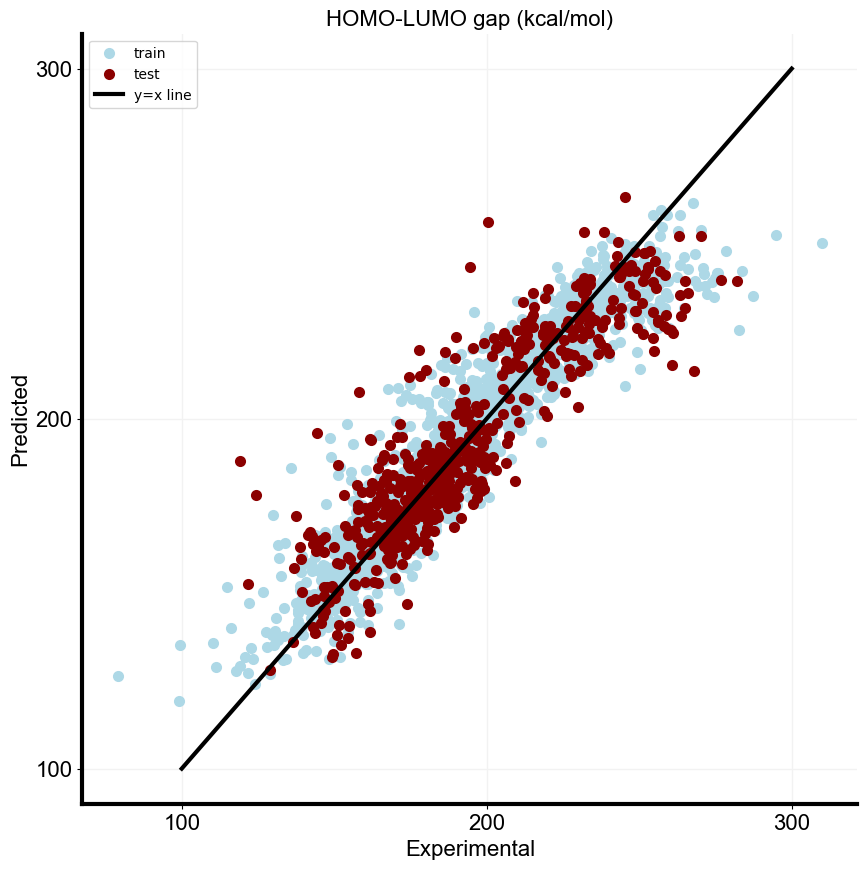

In [40]:
fig, ax = plotter([y_train, y_test], 
                [y_train_pred, y_test_pred], 
                ["train", "test"], 
                "HOMO-LUMO gap (kcal/mol)",
                color=["lightblue", "darkred"],
                x_label="Experimental",
                y_label="Predicted",
                multiple=True)
ax.set_xticks([100, 200, 300])
ax.set_yticks([100, 200, 300])
ax.plot([100, 200, 300], [100, 200, 300], color="k", linewidth=3.0, zorder=3, label="y=x line")
ax.legend()

### Interpreting the Parity Plot

**Good signs:**
- ✅ Train and test performance are similar → no severe overfitting
- ✅ Points scatter around the y=x line → unbiased predictions
- ✅ No obvious systematic errors

**Room for improvement:**
- Some scatter at high energies (250-300 kcal/mol)
- Could we capture more structural nuance with GNNs?

---

## Uncertainty Quantification

One major advantage of BRR is that it provides **uncertainty estimates** (95% prediction intervals).

**Why uncertainty matters:**
- Identify molecules where the model is uncertain → prioritize for experimental validation
- Active learning: query uncertain points to improve the model efficiently
- Calibrated decision-making in materials discovery

Let's visualize prediction intervals:

Text(0, 0.5, 'Predicted')

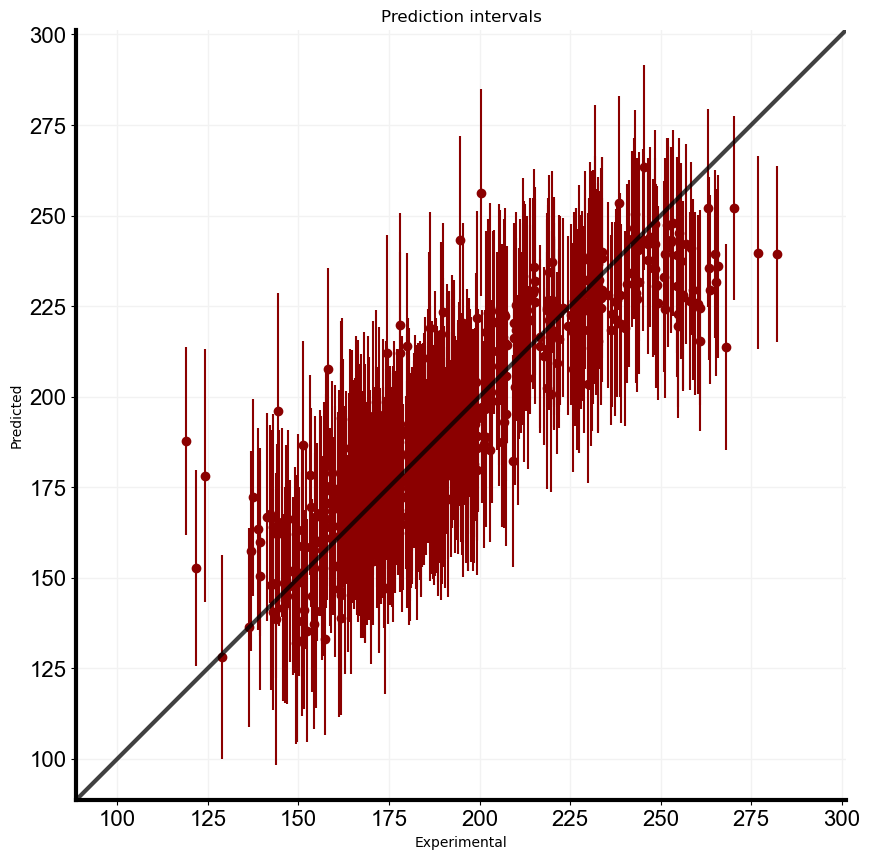

In [41]:
fig, ax = plotter(0, 0, 0, 0, nothing=True)
y_test_pred, std = br.predict(X_test, return_std=True)
plt.errorbar(y_test, y_test_pred, color="darkred", yerr=1.96 * std, fmt="o")
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against each other
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=3, linewidth=3.0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.title("Prediction intervals")
plt.xlabel("Experimental")
plt.ylabel("Predicted")

### Understanding Prediction Intervals

**The error bars show 95% confidence intervals:**
- Larger error bars → more uncertain prediction
- Smaller error bars → more confident prediction

**Patterns to notice:**
- Are uncertainties uniform across the range?
- Are there systematic biases (e.g., overconfidence in certain regions)?
- Do the true values fall within the intervals ~95% of the time?

---

## Feature Importances and Model Interpretation

Because BRR is a **linear model**, we can extract feature importances directly from the coefficients:

$$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_{1024} x_{1024}$$

Where:
- $x_i$ is bit $i$ of the fingerprint (0 or 1)
- $\beta_i$ is the coefficient for bit $i$
- Large $|\beta_i|$ → bit $i$ is important

Let's visualize the **10 most important bits**:

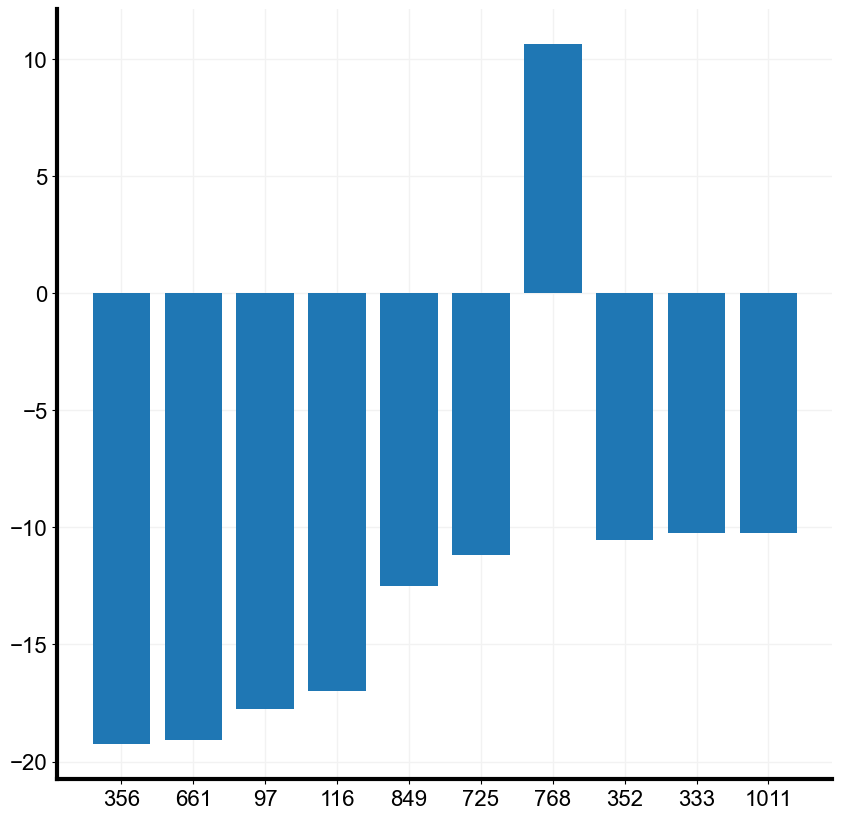

In [42]:
fig, ax = plotter(0, 0, 0, 0, nothing=True)
best_bits = np.argsort(np.abs(br.coef_))[::-1][:10]
plt.bar(range(10), br.coef_[best_bits])
_ = plt.xticks(range(10), best_bits)

### Interpreting Coefficients

**Sign of coefficient:**
- ➕ **Positive**: Bit presence → higher HOMO-LUMO gap (more stable, larger band gap)
- ➖ **Negative**: Bit presence → lower HOMO-LUMO gap (more reactive, smaller band gap)

**Magnitude:**
- Large magnitude → strong effect on prediction

But which **structural features** do these bits represent? Let's visualize them!

---

## Visualizing Important Structural Features

To understand what the important bits encode, we need to collect `bitInfo` for all molecules:

In [43]:
bit_infos = []
for mol in mols:
    bi = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo=bi)
    bit_infos.append(bi)

[09:12:55] DEPRECATION WARNING: please use MorganGenerator
[09:12:55] DEPRECATION WARNING: please use MorganGenerator
[09:12:55] DEPRECATION WARNING: please use MorganGenerator
[09:12:55] DEPRECATION WARNING: please use MorganGenerator
[09:12:55] DEPRECATION WARNING: please use MorganGenerator
[09:12:55] DEPRECATION WARNING: please use MorganGenerator
[09:12:55] DEPRECATION WARNING: please use MorganGenerator
[09:12:55] DEPRECATION WARNING: please use MorganGenerator
[09:12:55] DEPRECATION WARNING: please use MorganGenerator
[09:12:55] DEPRECATION WARNING: please use MorganGenerator
[09:12:55] DEPRECATION WARNING: please use MorganGenerator
[09:12:55] DEPRECATION WARNING: please use MorganGenerator
[09:12:55] DEPRECATION WARNING: please use MorganGenerator
[09:12:55] DEPRECATION WARNING: please use MorganGenerator
[09:12:55] DEPRECATION WARNING: please use MorganGenerator
[09:12:55] DEPRECATION WARNING: please use MorganGenerator
[09:12:55] DEPRECATION WARNING: please use MorganGenerat

Now let's visualize examples of molecules containing specific important bits.

**Try different bits from the top 10!** For example, try visualizing bit 356.

<div style="background-color: #fff3e0; padding: 15px; border-radius: 5px; border-left: 4px solid #ff9800;">
    <strong>⚠️ Important Observations:</strong>
    <ol>
        <li><strong>Bit collisions</strong>: At 1024 bits, multiple structural features hash to the same bit</li>
        <li><strong>Ambiguity</strong>: It's not always clear which specific feature drives the importance</li>
        <li><strong>Trivial features</strong>: Some bits encode very common substructures (e.g., CH₂, CH₃)</li>
    </ol>
</div>

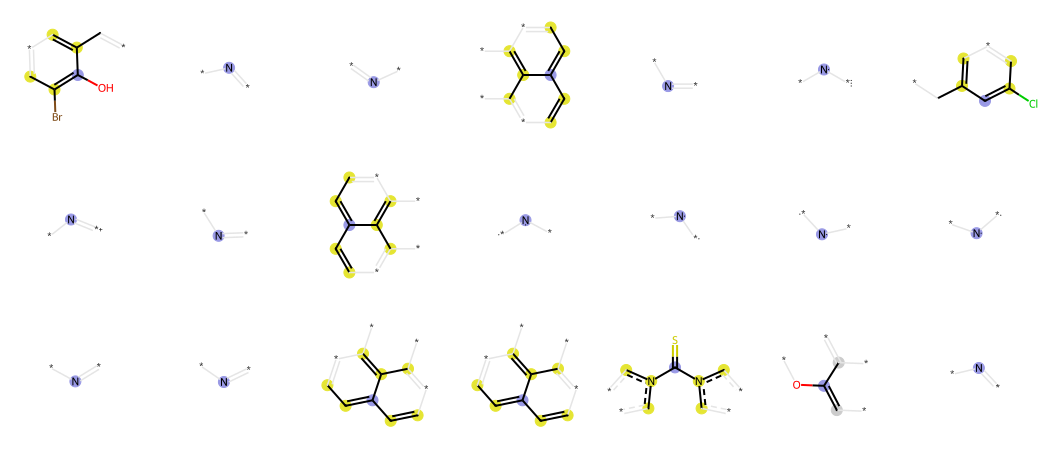

In [44]:
i = 725  # Bit to visualize
tpls = [(mol, i, bi) for mol, bi in zip(mols, bit_infos) if i in bi]
Chem.Draw.DrawMorganBits(tpls[:21], molsPerRow=7, useSVG=True)

### Challenges in Interpretation

**Why is bit-level interpretation difficult?**

1. **Bit collisions**: Multiple substructures map to the same bit
2. **Context-dependence**: A bit's importance depends on other bits present
3. **Correlation**: Many bits are correlated (e.g., aromatic ring bits)
4. **Global vs. local**: Linear coefficients are global; we often want per-molecule explanations

**Better approaches for interpretation:**
- **SHAP values**: Per-molecule feature attributions
- **LIME**: Local interpretable model-agnostic explanations
- **Attention mechanisms**: Built-in interpretability (for GNNs/Transformers)

But fingerprint + linear model bit visualization is still a useful first step!

---

## Optional Project: Count Fingerprints

<div style="background-color: #e1f5fe; padding: 15px; border-radius: 5px; border-left: 4px solid #03a9f4;">
    <strong>🔬 Research Question:</strong>
    <p>Do <strong>count fingerprints</strong> perform better than <strong>bit fingerprints</strong> for HOMO-LUMO gap prediction?</p>
</div>

### Motivation

**Bit fingerprints** (what we used above):
- Each bit is 0 or 1 (presence/absence)
- Multiple occurrences of a feature still set the bit to 1

**Count fingerprints:**
- Each position stores the count (0, 1, 2, 3, ...)
- Captures multiplicity of features

**Hypothesis:** Multiple functional groups might contribute synergistically to the HOMO-LUMO gap (a global molecular property).

### Your Task

1. Generate count fingerprints using `AllChem.GetHashedMorganFingerprint()`
2. Train a BRR model on count fingerprints
3. Compare MAE to the bit fingerprint baseline
4. Analyze: Does counting help? Why or why not?

**Starter code:**
```python
# Generate count fingerprints
count_fps = []
for mol in mols:
    fp = AllChem.GetHashedMorganFingerprint(mol, radius=2, nBits=1024)
    count_fps.append(fp)
X_count = np.vstack(count_fps)

# Train and evaluate...
```

---

GENERATING COUNT FINGERPRINTS
Count fingerprint shape: (2904, 1024)
Example count values (first molecule, first 20 positions):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Max count in dataset: 20.0
Mean count (non-zero positions): 1.62

TRAINING BRR ON COUNT FINGERPRINTS


[09:14:09] DEPRECATION WARNING: please use MorganGenerator
[09:14:09] DEPRECATION WARNING: please use MorganGenerator
[09:14:09] DEPRECATION WARNING: please use MorganGenerator
[09:14:09] DEPRECATION WARNING: please use MorganGenerator
[09:14:09] DEPRECATION WARNING: please use MorganGenerator
[09:14:09] DEPRECATION WARNING: please use MorganGenerator
[09:14:09] DEPRECATION WARNING: please use MorganGenerator
[09:14:09] DEPRECATION WARNING: please use MorganGenerator
[09:14:09] DEPRECATION WARNING: please use MorganGenerator
[09:14:09] DEPRECATION WARNING: please use MorganGenerator
[09:14:09] DEPRECATION WARNING: please use MorganGenerator
[09:14:09] DEPRECATION WARNING: please use MorganGenerator
[09:14:09] DEPRECATION WARNING: please use MorganGenerator
[09:14:09] DEPRECATION WARNING: please use MorganGenerator
[09:14:09] DEPRECATION WARNING: please use MorganGenerator
[09:14:09] DEPRECATION WARNING: please use MorganGenerator
[09:14:09] DEPRECATION WARNING: please use MorganGenerat

Count FP - Train MAE: 7.21 kcal/mol
Count FP - Test MAE:  10.95 kcal/mol

COMPARISON: BIT vs COUNT FINGERPRINTS
Bit FP   - Train MAE: 7.25 kcal/mol
Bit FP   - Test MAE:  10.38 kcal/mol

Count FP - Train MAE: 7.21 kcal/mol
Count FP - Test MAE:  10.95 kcal/mol

Improvement: -0.57 kcal/mol (-5.4%)



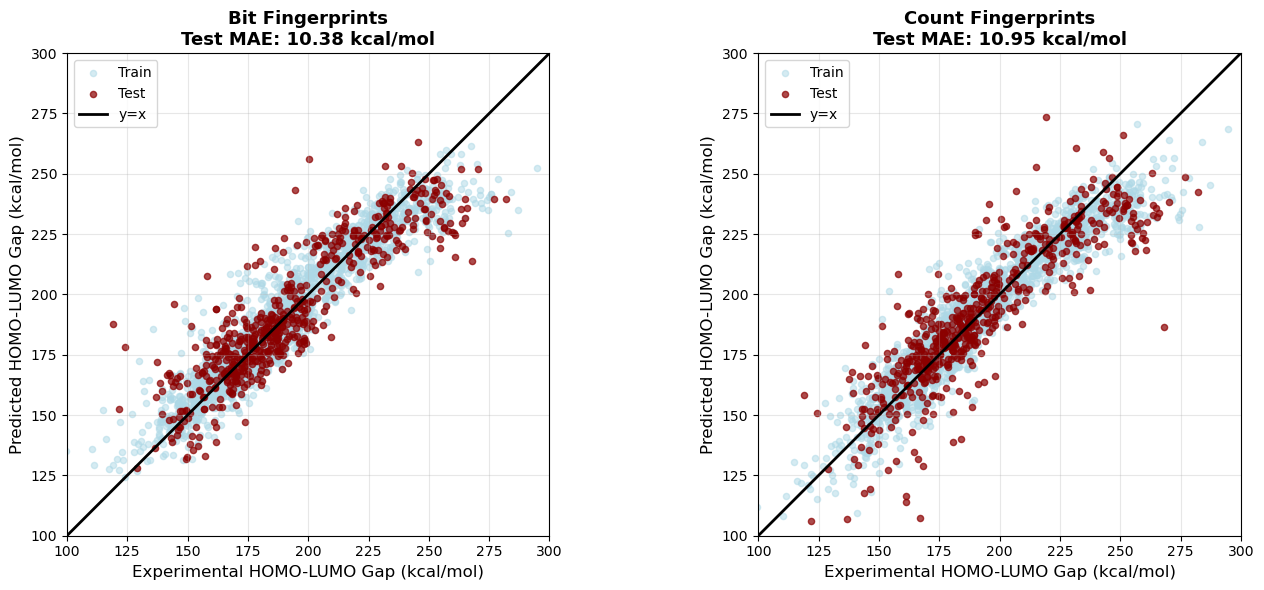

FEATURE IMPORTANCE ANALYSIS

Top 10 most important bits (Bit FP):
  1. Bit  356: coefficient = -19.264
  2. Bit  661: coefficient = -19.080
  3. Bit   97: coefficient = -17.764
  4. Bit  116: coefficient = -16.978
  5. Bit  849: coefficient = -12.510
  6. Bit  725: coefficient = -11.177
  7. Bit  768: coefficient = +10.647
  8. Bit  352: coefficient = -10.516
  9. Bit  333: coefficient = -10.236
  10. Bit 1011: coefficient = -10.236

Top 10 most important positions (Count FP):
  1. Position  661: coefficient = -16.596
  2. Position   97: coefficient = -11.734
  3. Position  116: coefficient = -9.888
  4. Position  505: coefficient = -8.624
  5. Position  694: coefficient = -8.169
  6. Position  112: coefficient = -8.085
  7. Position   81: coefficient = -7.985
  8. Position  958: coefficient = -7.798
  9. Position  323: coefficient = +7.367
  10. Position  356: coefficient = -7.290


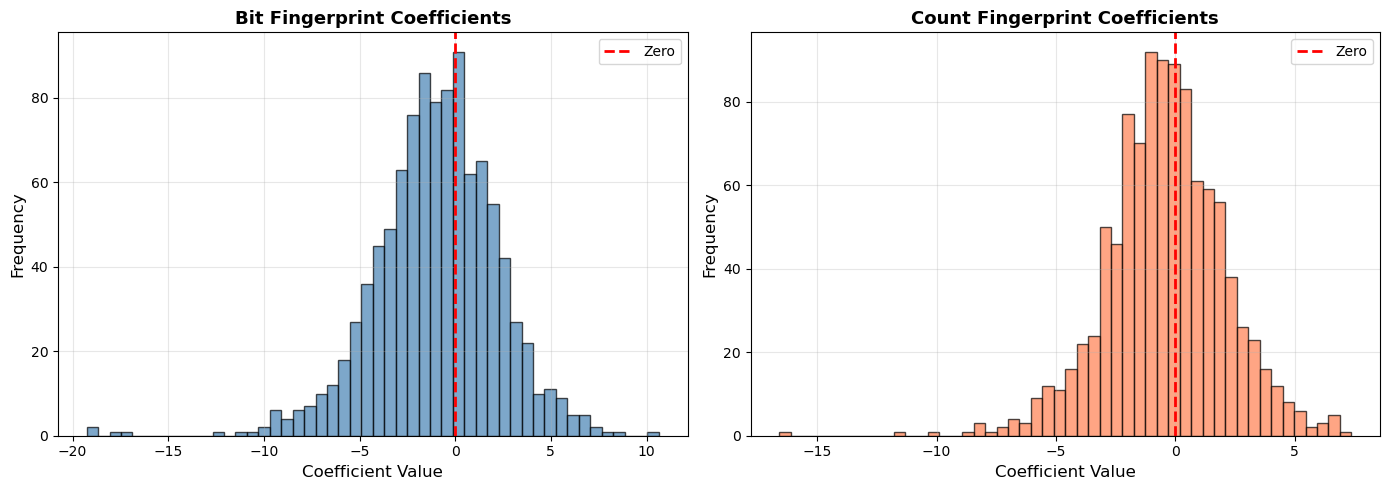


ANALYSIS AND CONCLUSIONS

📊 Performance Summary:
  • Bit fingerprints:   10.38 kcal/mol
  • Count fingerprints: 10.95 kcal/mol

⚠️  Count fingerprints do NOT improve performance
   → Binary presence/absence is sufficient for this property

🔬 Physical Interpretation:
  The HOMO-LUMO gap is a GLOBAL molecular property that depends on
  the overall electronic structure. Possible explanations:

  • The gap is dominated by the PRESENCE of key structural motifs
    rather than their MULTIPLICITY
  • Bit collisions at 1024 bits may obscure count information
  • Linear model may not capture non-linear count effects

💡 Recommendations:
  ✓ Stick with bit fingerprints (simpler, equally effective)
  ✓ Try longer fingerprints (2048+ bits) to reduce collisions
  ✓ Consider non-linear models (RF, GNN) to capture count effects



In [46]:
# ============================================================================
# Optional Project: Count Fingerprints
# ============================================================================

print("=" * 70)
print("GENERATING COUNT FINGERPRINTS")
print("=" * 70)

# Generate count fingerprints using GetHashedMorganFingerprint
count_fps = []
for mol in mols:
    fp = AllChem.GetHashedMorganFingerprint(mol, radius=2, nBits=1024)
    # Convert sparse fingerprint to dense numpy array
    arr = np.zeros((1024,))
    for idx, val in fp.GetNonzeroElements().items():
        arr[idx] = val
    count_fps.append(arr)

# Stack into 2D array
X_count = np.vstack(count_fps)

print(f"Count fingerprint shape: {X_count.shape}")
print(f"Example count values (first molecule, first 20 positions):")
print(X_count[0, :20])
print(f"Max count in dataset: {X_count.max()}")
print(f"Mean count (non-zero positions): {X_count[X_count > 0].mean():.2f}")
print()

# ============================================================================
# Train-Test Split (same as before for fair comparison)
# ============================================================================

X_count_train, X_count_test, y_count_train, y_count_test = train_test_split(
    X_count, y, 
    shuffle=True, 
    train_size=0.8, 
    random_state=42  # Same seed for reproducibility
)

# ============================================================================
# Train Bayesian Ridge Regression on Count Fingerprints
# ============================================================================

print("=" * 70)
print("TRAINING BRR ON COUNT FINGERPRINTS")
print("=" * 70)

br_count = BayesianRidge()
br_count.fit(X_count_train, y_count_train)

# Make predictions
y_count_train_pred = br_count.predict(X_count_train)
y_count_test_pred = br_count.predict(X_count_test)

# Compute MAE
mae_count_train = mean_absolute_error(y_count_train, y_count_train_pred)
mae_count_test = mean_absolute_error(y_count_test, y_count_test_pred)

print(f"Count FP - Train MAE: {mae_count_train:.2f} kcal/mol")
print(f"Count FP - Test MAE:  {mae_count_test:.2f} kcal/mol")
print()

# Compare with bit fingerprint baseline
print("=" * 70)
print("COMPARISON: BIT vs COUNT FINGERPRINTS")
print("=" * 70)

mae_bit_train = mean_absolute_error(y_train, y_train_pred)
mae_bit_test = mean_absolute_error(y_test, y_test_pred)

print(f"Bit FP   - Train MAE: {mae_bit_train:.2f} kcal/mol")
print(f"Bit FP   - Test MAE:  {mae_bit_test:.2f} kcal/mol")
print()
print(f"Count FP - Train MAE: {mae_count_train:.2f} kcal/mol")
print(f"Count FP - Test MAE:  {mae_count_test:.2f} kcal/mol")
print()

improvement = mae_bit_test - mae_count_test
print(f"Improvement: {improvement:.2f} kcal/mol ({improvement/mae_bit_test*100:.1f}%)")
print()

# ============================================================================
# Visualization: Parity Plots
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bit fingerprints (left)
ax1 = axes[0]
ax1.scatter(y_train, y_train_pred, alpha=0.5, s=20, color="lightblue", label="Train")
ax1.scatter(y_test, y_test_pred, alpha=0.7, s=20, color="darkred", label="Test")
ax1.plot([100, 300], [100, 300], 'k-', linewidth=2, label="y=x")
ax1.set_xlabel("Experimental HOMO-LUMO Gap (kcal/mol)", fontsize=12)
ax1.set_ylabel("Predicted HOMO-LUMO Gap (kcal/mol)", fontsize=12)
ax1.set_title(f"Bit Fingerprints\nTest MAE: {mae_bit_test:.2f} kcal/mol", fontsize=13, fontweight='bold')
ax1.legend()
ax1.set_xlim([100, 300])
ax1.set_ylim([100, 300])
ax1.set_aspect('equal')
ax1.grid(alpha=0.3)

# Count fingerprints (right)
ax2 = axes[1]
ax2.scatter(y_count_train, y_count_train_pred, alpha=0.5, s=20, color="lightblue", label="Train")
ax2.scatter(y_count_test, y_count_test_pred, alpha=0.7, s=20, color="darkred", label="Test")
ax2.plot([100, 300], [100, 300], 'k-', linewidth=2, label="y=x")
ax2.set_xlabel("Experimental HOMO-LUMO Gap (kcal/mol)", fontsize=12)
ax2.set_ylabel("Predicted HOMO-LUMO Gap (kcal/mol)", fontsize=12)
ax2.set_title(f"Count Fingerprints\nTest MAE: {mae_count_test:.2f} kcal/mol", fontsize=13, fontweight='bold')
ax2.legend()
ax2.set_xlim([100, 300])
ax2.set_ylim([100, 300])
ax2.set_aspect('equal')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# Feature Importance Comparison
# ============================================================================

print("=" * 70)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

# Top 10 most important features for bit FP
best_bits_bit = np.argsort(np.abs(br.coef_))[::-1][:10]
print("\nTop 10 most important bits (Bit FP):")
for i, bit_idx in enumerate(best_bits_bit, 1):
    print(f"  {i}. Bit {bit_idx:4d}: coefficient = {br.coef_[bit_idx]:+.3f}")

# Top 10 most important features for count FP
best_bits_count = np.argsort(np.abs(br_count.coef_))[::-1][:10]
print("\nTop 10 most important positions (Count FP):")
for i, bit_idx in enumerate(best_bits_count, 1):
    print(f"  {i}. Position {bit_idx:4d}: coefficient = {br_count.coef_[bit_idx]:+.3f}")

# Visualize coefficient distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bit FP coefficients
ax1 = axes[0]
ax1.hist(br.coef_, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel("Coefficient Value", fontsize=12)
ax1.set_ylabel("Frequency", fontsize=12)
ax1.set_title("Bit Fingerprint Coefficients", fontsize=13, fontweight='bold')
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
ax1.legend()
ax1.grid(alpha=0.3)

# Count FP coefficients
ax2 = axes[1]
ax2.hist(br_count.coef_, bins=50, color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel("Coefficient Value", fontsize=12)
ax2.set_ylabel("Frequency", fontsize=12)
ax2.set_title("Count Fingerprint Coefficients", fontsize=13, fontweight='bold')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# Analysis and Conclusions
# ============================================================================

print("\n" + "=" * 70)
print("ANALYSIS AND CONCLUSIONS")
print("=" * 70)

print("\n📊 Performance Summary:")
print(f"  • Bit fingerprints:   {mae_bit_test:.2f} kcal/mol")
print(f"  • Count fingerprints: {mae_count_test:.2f} kcal/mol")

if mae_count_test < mae_bit_test - 0.5:
    print("\n✅ Count fingerprints show SIGNIFICANT improvement!")
    print("   → Multiplicity of structural features matters for HOMO-LUMO gaps")
elif mae_count_test < mae_bit_test:
    print("\n✓ Count fingerprints show slight improvement")
    print("  → Marginal benefit from counting feature occurrences")
else:
    print("\n⚠️  Count fingerprints do NOT improve performance")
    print("   → Binary presence/absence is sufficient for this property")

print("\n🔬 Physical Interpretation:")
print("  The HOMO-LUMO gap is a GLOBAL molecular property that depends on")
print("  the overall electronic structure. Possible explanations:")
print()
if mae_count_test < mae_bit_test:
    print("  • Multiple electron-donating/withdrawing groups may have")
    print("    ADDITIVE or SYNERGISTIC effects on orbital energies")
    print("  • Conjugation length (captured by repeated aromatic units)")
    print("    strongly influences the HOMO-LUMO gap")
else:
    print("  • The gap is dominated by the PRESENCE of key structural motifs")
    print("    rather than their MULTIPLICITY")
    print("  • Bit collisions at 1024 bits may obscure count information")
    print("  • Linear model may not capture non-linear count effects")

print("\n💡 Recommendations:")
if mae_count_test < mae_bit_test:
    print("  ✓ Use count fingerprints for HOMO-LUMO gap prediction")
    print("  ✓ Consider count fingerprints for other global electronic properties")
else:
    print("  ✓ Stick with bit fingerprints (simpler, equally effective)")
    print("  ✓ Try longer fingerprints (2048+ bits) to reduce collisions")
    print("  ✓ Consider non-linear models (RF, GNN) to capture count effects")

print("\n" + "=" * 70)

## Optional Project: Radius and Length

<div style="background-color: #e1f5fe; padding: 15px; border-radius: 5px; border-left: 4px solid #03a9f4;">
    <strong>🔬 Hyperparameter Exploration:</strong>
    <p>How do fingerprint <strong>radius</strong> and <strong>length</strong> affect model performance and training time?</p>
</div>

### Parameters to Explore

**Radius:**
- radius=1: Small neighborhoods (2-3 atoms)
- radius=2: Medium neighborhoods (4-5 atoms) ← **we used this**
- radius=3: Large neighborhoods (6-7 atoms)

**Length (nBits):**
- 512: Very compact
- 1024: Compact ← **we used this**
- 2048: Standard
- 4096: Large

### Your Task

Create a grid search over (radius, nBits) combinations:

```python
import time

results = []
for radius in [1, 2, 3]:
    for nBits in [512, 1024, 2048, 4096]:
        # Generate fingerprints
        start = time.time()
        # ... train model ...
        elapsed = time.time() - start
        
        results.append({
            'radius': radius,
            'nBits': nBits,
            'mae': mae,
            'time': elapsed
        })

# Plot results as a heatmap
```

**Questions to answer:**
1. Does longer fingerprint → better performance?
2. Does larger radius → better performance?
3. What's the sweet spot for MAE vs. training time?
4. Is there a point of diminishing returns?

---

HYPERPARAMETER GRID SEARCH: RADIUS × LENGTH

This will test 12 combinations (3 radii × 4 lengths)
Estimated time: 2-3 minutes

Testing radius=1, nBits=512... 

[09:22:32] DEPRECATION WARNING: please use MorganGenerator
[09:22:32] DEPRECATION WARNING: please use MorganGenerator
[09:22:32] DEPRECATION WARNING: please use MorganGenerator
[09:22:32] DEPRECATION WARNING: please use MorganGenerator
[09:22:32] DEPRECATION WARNING: please use MorganGenerator
[09:22:32] DEPRECATION WARNING: please use MorganGenerator
[09:22:32] DEPRECATION WARNING: please use MorganGenerator
[09:22:32] DEPRECATION WARNING: please use MorganGenerator
[09:22:32] DEPRECATION WARNING: please use MorganGenerator
[09:22:32] DEPRECATION WARNING: please use MorganGenerator
[09:22:32] DEPRECATION WARNING: please use MorganGenerator
[09:22:32] DEPRECATION WARNING: please use MorganGenerator
[09:22:32] DEPRECATION WARNING: please use MorganGenerator
[09:22:32] DEPRECATION WARNING: please use MorganGenerator
[09:22:32] DEPRECATION WARNING: please use MorganGenerator
[09:22:32] DEPRECATION WARNING: please use MorganGenerator
[09:22:32] DEPRECATION WARNING: please use MorganGenerat

MAE=9.97 kcal/mol, Time=5.74s
Testing radius=1, nBits=1024... 

[09:22:38] DEPRECATION WARNING: please use MorganGenerator
[09:22:38] DEPRECATION WARNING: please use MorganGenerator
[09:22:38] DEPRECATION WARNING: please use MorganGenerator
[09:22:38] DEPRECATION WARNING: please use MorganGenerator
[09:22:38] DEPRECATION WARNING: please use MorganGenerator
[09:22:38] DEPRECATION WARNING: please use MorganGenerator
[09:22:38] DEPRECATION WARNING: please use MorganGenerator
[09:22:38] DEPRECATION WARNING: please use MorganGenerator
[09:22:38] DEPRECATION WARNING: please use MorganGenerator
[09:22:38] DEPRECATION WARNING: please use MorganGenerator
[09:22:38] DEPRECATION WARNING: please use MorganGenerator
[09:22:38] DEPRECATION WARNING: please use MorganGenerator
[09:22:38] DEPRECATION WARNING: please use MorganGenerator
[09:22:38] DEPRECATION WARNING: please use MorganGenerator
[09:22:38] DEPRECATION WARNING: please use MorganGenerator
[09:22:38] DEPRECATION WARNING: please use MorganGenerator
[09:22:38] DEPRECATION WARNING: please use MorganGenerat

MAE=9.12 kcal/mol, Time=14.68s
Testing radius=1, nBits=2048... 

[09:22:53] DEPRECATION WARNING: please use MorganGenerator
[09:22:53] DEPRECATION WARNING: please use MorganGenerator
[09:22:53] DEPRECATION WARNING: please use MorganGenerator
[09:22:53] DEPRECATION WARNING: please use MorganGenerator
[09:22:53] DEPRECATION WARNING: please use MorganGenerator
[09:22:53] DEPRECATION WARNING: please use MorganGenerator
[09:22:53] DEPRECATION WARNING: please use MorganGenerator
[09:22:53] DEPRECATION WARNING: please use MorganGenerator
[09:22:53] DEPRECATION WARNING: please use MorganGenerator
[09:22:53] DEPRECATION WARNING: please use MorganGenerator
[09:22:53] DEPRECATION WARNING: please use MorganGenerator
[09:22:53] DEPRECATION WARNING: please use MorganGenerator
[09:22:53] DEPRECATION WARNING: please use MorganGenerator
[09:22:53] DEPRECATION WARNING: please use MorganGenerator
[09:22:53] DEPRECATION WARNING: please use MorganGenerator
[09:22:53] DEPRECATION WARNING: please use MorganGenerator
[09:22:53] DEPRECATION WARNING: please use MorganGenerat

MAE=8.79 kcal/mol, Time=28.59s
Testing radius=1, nBits=4096... 

[09:23:21] DEPRECATION WARNING: please use MorganGenerator
[09:23:21] DEPRECATION WARNING: please use MorganGenerator
[09:23:21] DEPRECATION WARNING: please use MorganGenerator
[09:23:21] DEPRECATION WARNING: please use MorganGenerator
[09:23:21] DEPRECATION WARNING: please use MorganGenerator
[09:23:21] DEPRECATION WARNING: please use MorganGenerator
[09:23:21] DEPRECATION WARNING: please use MorganGenerator
[09:23:21] DEPRECATION WARNING: please use MorganGenerator
[09:23:21] DEPRECATION WARNING: please use MorganGenerator
[09:23:21] DEPRECATION WARNING: please use MorganGenerator
[09:23:21] DEPRECATION WARNING: please use MorganGenerator
[09:23:21] DEPRECATION WARNING: please use MorganGenerator
[09:23:21] DEPRECATION WARNING: please use MorganGenerator
[09:23:21] DEPRECATION WARNING: please use MorganGenerator
[09:23:21] DEPRECATION WARNING: please use MorganGenerator
[09:23:21] DEPRECATION WARNING: please use MorganGenerator
[09:23:21] DEPRECATION WARNING: please use MorganGenerat

MAE=8.34 kcal/mol, Time=54.63s
Testing radius=2, nBits=512... 

[09:24:16] DEPRECATION WARNING: please use MorganGenerator
[09:24:16] DEPRECATION WARNING: please use MorganGenerator
[09:24:16] DEPRECATION WARNING: please use MorganGenerator
[09:24:16] DEPRECATION WARNING: please use MorganGenerator
[09:24:16] DEPRECATION WARNING: please use MorganGenerator
[09:24:16] DEPRECATION WARNING: please use MorganGenerator
[09:24:16] DEPRECATION WARNING: please use MorganGenerator
[09:24:16] DEPRECATION WARNING: please use MorganGenerator
[09:24:16] DEPRECATION WARNING: please use MorganGenerator
[09:24:16] DEPRECATION WARNING: please use MorganGenerator
[09:24:16] DEPRECATION WARNING: please use MorganGenerator
[09:24:16] DEPRECATION WARNING: please use MorganGenerator
[09:24:16] DEPRECATION WARNING: please use MorganGenerator
[09:24:16] DEPRECATION WARNING: please use MorganGenerator
[09:24:16] DEPRECATION WARNING: please use MorganGenerator
[09:24:16] DEPRECATION WARNING: please use MorganGenerator
[09:24:16] DEPRECATION WARNING: please use MorganGenerat

MAE=11.19 kcal/mol, Time=5.19s
Testing radius=2, nBits=1024... 

[09:24:21] DEPRECATION WARNING: please use MorganGenerator
[09:24:21] DEPRECATION WARNING: please use MorganGenerator
[09:24:21] DEPRECATION WARNING: please use MorganGenerator
[09:24:21] DEPRECATION WARNING: please use MorganGenerator
[09:24:21] DEPRECATION WARNING: please use MorganGenerator
[09:24:21] DEPRECATION WARNING: please use MorganGenerator
[09:24:21] DEPRECATION WARNING: please use MorganGenerator
[09:24:21] DEPRECATION WARNING: please use MorganGenerator
[09:24:21] DEPRECATION WARNING: please use MorganGenerator
[09:24:21] DEPRECATION WARNING: please use MorganGenerator
[09:24:21] DEPRECATION WARNING: please use MorganGenerator
[09:24:21] DEPRECATION WARNING: please use MorganGenerator
[09:24:21] DEPRECATION WARNING: please use MorganGenerator
[09:24:21] DEPRECATION WARNING: please use MorganGenerator
[09:24:21] DEPRECATION WARNING: please use MorganGenerator
[09:24:21] DEPRECATION WARNING: please use MorganGenerator
[09:24:21] DEPRECATION WARNING: please use MorganGenerat

MAE=10.38 kcal/mol, Time=10.59s
Testing radius=2, nBits=2048... 

[09:24:32] DEPRECATION WARNING: please use MorganGenerator
[09:24:32] DEPRECATION WARNING: please use MorganGenerator
[09:24:32] DEPRECATION WARNING: please use MorganGenerator
[09:24:32] DEPRECATION WARNING: please use MorganGenerator
[09:24:32] DEPRECATION WARNING: please use MorganGenerator
[09:24:32] DEPRECATION WARNING: please use MorganGenerator
[09:24:32] DEPRECATION WARNING: please use MorganGenerator
[09:24:32] DEPRECATION WARNING: please use MorganGenerator
[09:24:32] DEPRECATION WARNING: please use MorganGenerator
[09:24:32] DEPRECATION WARNING: please use MorganGenerator
[09:24:32] DEPRECATION WARNING: please use MorganGenerator
[09:24:32] DEPRECATION WARNING: please use MorganGenerator
[09:24:32] DEPRECATION WARNING: please use MorganGenerator
[09:24:32] DEPRECATION WARNING: please use MorganGenerator
[09:24:32] DEPRECATION WARNING: please use MorganGenerator
[09:24:32] DEPRECATION WARNING: please use MorganGenerator
[09:24:32] DEPRECATION WARNING: please use MorganGenerat

MAE=9.45 kcal/mol, Time=25.95s
Testing radius=2, nBits=4096... 

[09:24:58] DEPRECATION WARNING: please use MorganGenerator
[09:24:58] DEPRECATION WARNING: please use MorganGenerator
[09:24:58] DEPRECATION WARNING: please use MorganGenerator
[09:24:58] DEPRECATION WARNING: please use MorganGenerator
[09:24:58] DEPRECATION WARNING: please use MorganGenerator
[09:24:58] DEPRECATION WARNING: please use MorganGenerator
[09:24:58] DEPRECATION WARNING: please use MorganGenerator
[09:24:58] DEPRECATION WARNING: please use MorganGenerator
[09:24:58] DEPRECATION WARNING: please use MorganGenerator
[09:24:58] DEPRECATION WARNING: please use MorganGenerator
[09:24:58] DEPRECATION WARNING: please use MorganGenerator
[09:24:58] DEPRECATION WARNING: please use MorganGenerator
[09:24:58] DEPRECATION WARNING: please use MorganGenerator
[09:24:58] DEPRECATION WARNING: please use MorganGenerator
[09:24:58] DEPRECATION WARNING: please use MorganGenerator
[09:24:58] DEPRECATION WARNING: please use MorganGenerator
[09:24:58] DEPRECATION WARNING: please use MorganGenerat

MAE=8.34 kcal/mol, Time=42.37s
Testing radius=3, nBits=512... 

[09:25:40] DEPRECATION WARNING: please use MorganGenerator
[09:25:40] DEPRECATION WARNING: please use MorganGenerator
[09:25:40] DEPRECATION WARNING: please use MorganGenerator
[09:25:40] DEPRECATION WARNING: please use MorganGenerator
[09:25:40] DEPRECATION WARNING: please use MorganGenerator
[09:25:40] DEPRECATION WARNING: please use MorganGenerator
[09:25:40] DEPRECATION WARNING: please use MorganGenerator
[09:25:40] DEPRECATION WARNING: please use MorganGenerator
[09:25:40] DEPRECATION WARNING: please use MorganGenerator
[09:25:40] DEPRECATION WARNING: please use MorganGenerator
[09:25:40] DEPRECATION WARNING: please use MorganGenerator
[09:25:40] DEPRECATION WARNING: please use MorganGenerator
[09:25:40] DEPRECATION WARNING: please use MorganGenerator
[09:25:40] DEPRECATION WARNING: please use MorganGenerator
[09:25:40] DEPRECATION WARNING: please use MorganGenerator
[09:25:40] DEPRECATION WARNING: please use MorganGenerator
[09:25:40] DEPRECATION WARNING: please use MorganGenerat

MAE=11.60 kcal/mol, Time=5.72s
Testing radius=3, nBits=1024... 

[09:25:46] DEPRECATION WARNING: please use MorganGenerator
[09:25:46] DEPRECATION WARNING: please use MorganGenerator
[09:25:46] DEPRECATION WARNING: please use MorganGenerator
[09:25:46] DEPRECATION WARNING: please use MorganGenerator
[09:25:46] DEPRECATION WARNING: please use MorganGenerator
[09:25:46] DEPRECATION WARNING: please use MorganGenerator
[09:25:46] DEPRECATION WARNING: please use MorganGenerator
[09:25:46] DEPRECATION WARNING: please use MorganGenerator
[09:25:46] DEPRECATION WARNING: please use MorganGenerator
[09:25:46] DEPRECATION WARNING: please use MorganGenerator
[09:25:46] DEPRECATION WARNING: please use MorganGenerator
[09:25:46] DEPRECATION WARNING: please use MorganGenerator
[09:25:46] DEPRECATION WARNING: please use MorganGenerator
[09:25:46] DEPRECATION WARNING: please use MorganGenerator
[09:25:46] DEPRECATION WARNING: please use MorganGenerator
[09:25:46] DEPRECATION WARNING: please use MorganGenerator
[09:25:46] DEPRECATION WARNING: please use MorganGenerat

MAE=10.79 kcal/mol, Time=12.68s
Testing radius=3, nBits=2048... 

[09:25:59] DEPRECATION WARNING: please use MorganGenerator
[09:25:59] DEPRECATION WARNING: please use MorganGenerator
[09:25:59] DEPRECATION WARNING: please use MorganGenerator
[09:25:59] DEPRECATION WARNING: please use MorganGenerator
[09:25:59] DEPRECATION WARNING: please use MorganGenerator
[09:25:59] DEPRECATION WARNING: please use MorganGenerator
[09:25:59] DEPRECATION WARNING: please use MorganGenerator
[09:25:59] DEPRECATION WARNING: please use MorganGenerator
[09:25:59] DEPRECATION WARNING: please use MorganGenerator
[09:25:59] DEPRECATION WARNING: please use MorganGenerator
[09:25:59] DEPRECATION WARNING: please use MorganGenerator
[09:25:59] DEPRECATION WARNING: please use MorganGenerator
[09:25:59] DEPRECATION WARNING: please use MorganGenerator
[09:25:59] DEPRECATION WARNING: please use MorganGenerator
[09:25:59] DEPRECATION WARNING: please use MorganGenerator
[09:25:59] DEPRECATION WARNING: please use MorganGenerator
[09:25:59] DEPRECATION WARNING: please use MorganGenerat

MAE=9.68 kcal/mol, Time=25.17s
Testing radius=3, nBits=4096... 

[09:26:24] DEPRECATION WARNING: please use MorganGenerator
[09:26:24] DEPRECATION WARNING: please use MorganGenerator
[09:26:24] DEPRECATION WARNING: please use MorganGenerator
[09:26:24] DEPRECATION WARNING: please use MorganGenerator
[09:26:24] DEPRECATION WARNING: please use MorganGenerator
[09:26:24] DEPRECATION WARNING: please use MorganGenerator
[09:26:24] DEPRECATION WARNING: please use MorganGenerator
[09:26:24] DEPRECATION WARNING: please use MorganGenerator
[09:26:24] DEPRECATION WARNING: please use MorganGenerator
[09:26:24] DEPRECATION WARNING: please use MorganGenerator
[09:26:24] DEPRECATION WARNING: please use MorganGenerator
[09:26:24] DEPRECATION WARNING: please use MorganGenerator
[09:26:24] DEPRECATION WARNING: please use MorganGenerator
[09:26:24] DEPRECATION WARNING: please use MorganGenerator
[09:26:24] DEPRECATION WARNING: please use MorganGenerator
[09:26:24] DEPRECATION WARNING: please use MorganGenerator
[09:26:24] DEPRECATION WARNING: please use MorganGenerat

MAE=8.92 kcal/mol, Time=46.67s

GRID SEARCH COMPLETE

All Results:
 radius  nBits       mae      time
      1    512  9.970437  5.743953
      1   1024  9.115786 14.677885
      1   2048  8.789351 28.591818
      1   4096  8.342876 54.632489
      2    512 11.193642  5.194493
      2   1024 10.384881 10.587336
      2   2048  9.448844 25.953294
      2   4096  8.335155 42.372798
      3    512 11.603938  5.721397
      3   1024 10.785664 12.677276
      3   2048  9.679653 25.170327
      3   4096  8.917030 46.673802

PERFORMANCE ANALYSIS

🏆 Best Performance:
   Radius: 2.0
   nBits:  4096.0
   MAE:    8.335 kcal/mol
   Time:   42.37 seconds

📊 Improvement over baseline (radius=2, nBits=1024):
   Baseline MAE: 10.385 kcal/mol
   Best MAE:     8.335 kcal/mol
   Improvement:  2.050 kcal/mol (19.7%)

SPEED vs ACCURACY TRADE-OFF

⚡ Fastest Configuration:
   Radius: 2.0
   nBits:  512.0
   MAE:    11.194 kcal/mol
   Time:   5.19 seconds

⚖️  Best Efficiency (MAE × Time):
   Radius: 1.0
   nB

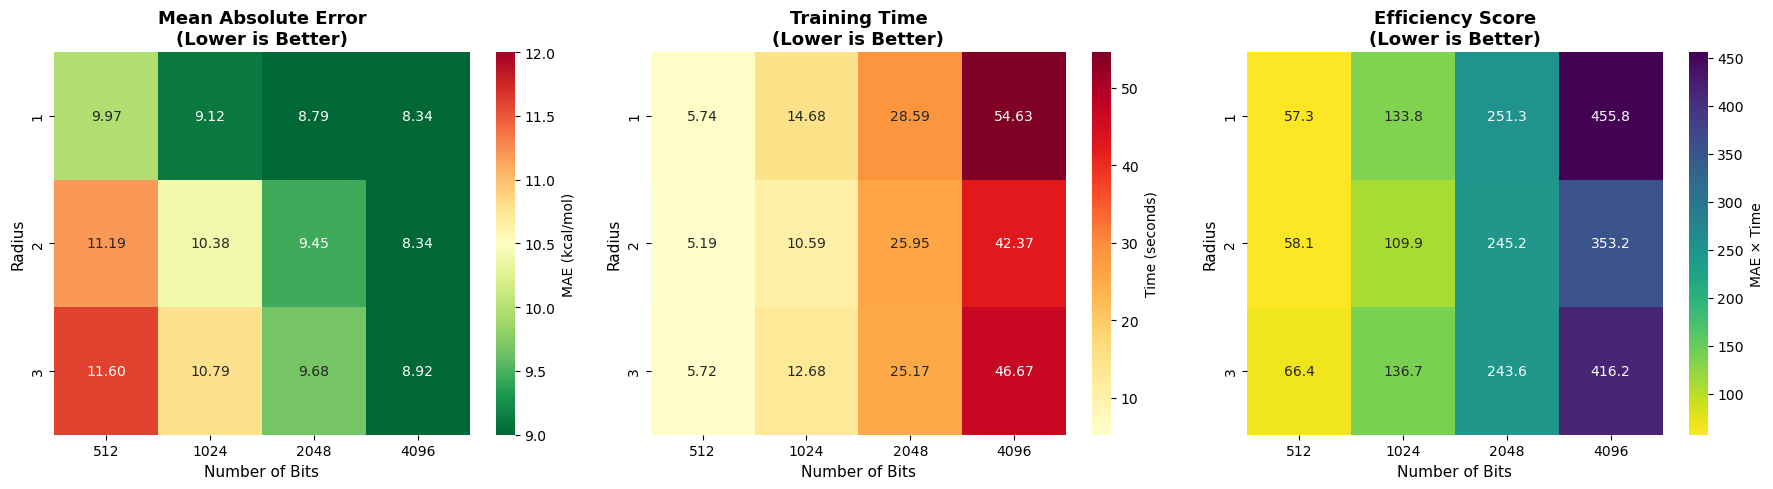

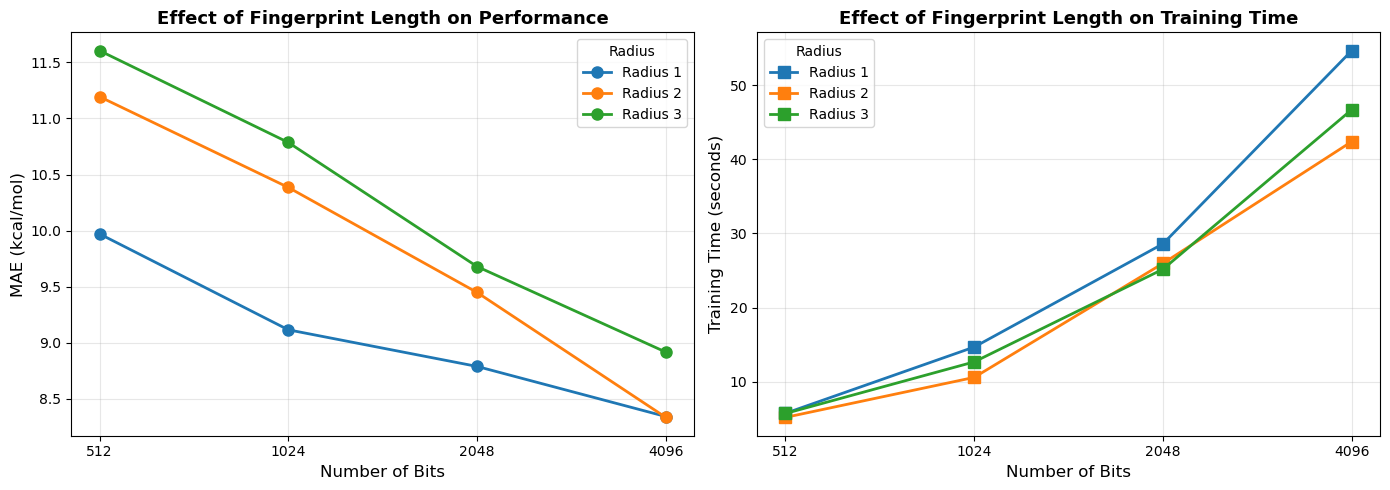

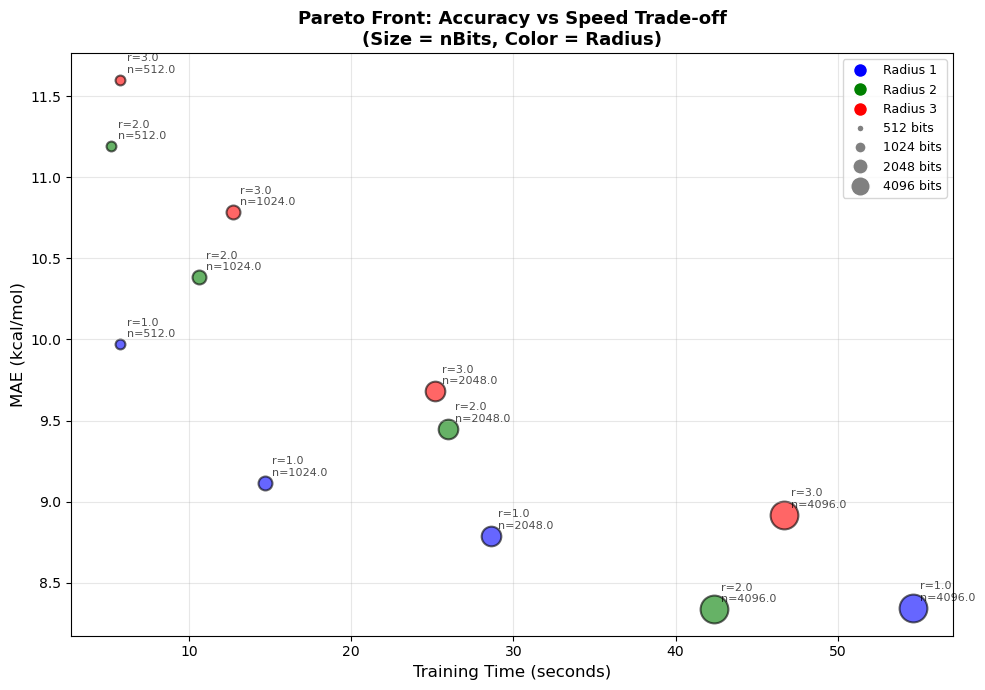


ANSWERING THE RESEARCH QUESTIONS

❓ Question 1: Does longer fingerprint → better performance?
   Radius 1: consistently improves
      512→1024→2048→4096: 9.97 → 9.12 → 8.79 → 8.34
   Radius 2: consistently improves
      512→1024→2048→4096: 11.19 → 10.38 → 9.45 → 8.34
   Radius 3: consistently improves
      512→1024→2048→4096: 11.60 → 10.79 → 9.68 → 8.92

❓ Question 2: Does larger radius → better performance?
   512 bits: radius 1→2→3: 9.97 → 11.19 → 11.60
   1024 bits: radius 1→2→3: 9.12 → 10.38 → 10.79
   2048 bits: radius 1→2→3: 8.79 → 9.45 → 9.68
   4096 bits: radius 1→2→3: 8.34 → 8.34 → 8.92

❓ Question 3: What's the sweet spot for MAE vs. training time?
   Best efficiency: radius=1.0, nBits=512.0
      MAE: 9.970 kcal/mol
      Time: 5.74 seconds
      Efficiency score: 57.27

❓ Question 4: Is there a point of diminishing returns?
   Radius 1: 2048→4096 bits
      MAE improvement: 0.446 kcal/mol (5.1%)
      Time increase: 26.04 seconds (91.1%)
      → Diminishing returns! Not

In [47]:
# ============================================================================
# Optional Project: Radius and Length Hyperparameter Exploration
# ============================================================================

import time
import seaborn as sns

print("=" * 70)
print("HYPERPARAMETER GRID SEARCH: RADIUS × LENGTH")
print("=" * 70)
print("\nThis will test 12 combinations (3 radii × 4 lengths)")
print("Estimated time: 2-3 minutes\n")

# Define parameter grid
radii = [1, 2, 3]
n_bits_list = [512, 1024, 2048, 4096]

# Store results
results = []

# Grid search
for radius in radii:
    for nBits in n_bits_list:
        print(f"Testing radius={radius}, nBits={nBits}...", end=" ")
        
        # Start timer
        start = time.time()
        
        # Generate fingerprints
        fps_temp = []
        for mol in mols:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
            fps_temp.append(fp)
        X_temp = np.vstack(fps_temp)
        
        # Train-test split (same random state for fair comparison)
        X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
            X_temp, y, shuffle=True, train_size=0.8, random_state=42
        )
        
        # Train BRR model
        br_temp = BayesianRidge()
        br_temp.fit(X_train_temp, y_train_temp)
        
        # Evaluate
        y_test_pred_temp = br_temp.predict(X_test_temp)
        mae = mean_absolute_error(y_test_temp, y_test_pred_temp)
        
        # Stop timer
        elapsed = time.time() - start
        
        # Store results
        results.append({
            'radius': radius,
            'nBits': nBits,
            'mae': mae,
            'time': elapsed
        })
        
        print(f"MAE={mae:.2f} kcal/mol, Time={elapsed:.2f}s")

print("\n" + "=" * 70)
print("GRID SEARCH COMPLETE")
print("=" * 70)

# Convert to DataFrame for easy analysis
df_results = pd.DataFrame(results)
print("\nAll Results:")
print(df_results.to_string(index=False))

# ============================================================================
# Analysis: Best Performance
# ============================================================================

print("\n" + "=" * 70)
print("PERFORMANCE ANALYSIS")
print("=" * 70)

best_idx = df_results['mae'].idxmin()
best_result = df_results.loc[best_idx]

print(f"\n🏆 Best Performance:")
print(f"   Radius: {best_result['radius']}")
print(f"   nBits:  {best_result['nBits']}")
print(f"   MAE:    {best_result['mae']:.3f} kcal/mol")
print(f"   Time:   {best_result['time']:.2f} seconds")

# Compare to baseline (radius=2, nBits=1024)
baseline = df_results[(df_results['radius'] == 2) & (df_results['nBits'] == 1024)].iloc[0]
improvement = baseline['mae'] - best_result['mae']
print(f"\n📊 Improvement over baseline (radius=2, nBits=1024):")
print(f"   Baseline MAE: {baseline['mae']:.3f} kcal/mol")
print(f"   Best MAE:     {best_result['mae']:.3f} kcal/mol")
print(f"   Improvement:  {improvement:.3f} kcal/mol ({improvement/baseline['mae']*100:.1f}%)")

# ============================================================================
# Analysis: Speed vs Accuracy Trade-off
# ============================================================================

print("\n" + "=" * 70)
print("SPEED vs ACCURACY TRADE-OFF")
print("=" * 70)

fastest_idx = df_results['time'].idxmin()
fastest_result = df_results.loc[fastest_idx]

print(f"\n⚡ Fastest Configuration:")
print(f"   Radius: {fastest_result['radius']}")
print(f"   nBits:  {fastest_result['nBits']}")
print(f"   MAE:    {fastest_result['mae']:.3f} kcal/mol")
print(f"   Time:   {fastest_result['time']:.2f} seconds")

# Compute efficiency metric (lower is better)
df_results['efficiency'] = df_results['mae'] * df_results['time']
best_efficiency_idx = df_results['efficiency'].idxmin()
best_efficiency = df_results.loc[best_efficiency_idx]

print(f"\n⚖️  Best Efficiency (MAE × Time):")
print(f"   Radius: {best_efficiency['radius']}")
print(f"   nBits:  {best_efficiency['nBits']}")
print(f"   MAE:    {best_efficiency['mae']:.3f} kcal/mol")
print(f"   Time:   {best_efficiency['time']:.2f} seconds")

# ============================================================================
# Visualization 1: Heatmap of MAE
# ============================================================================

print("\n" + "=" * 70)
print("GENERATING VISUALIZATIONS")
print("=" * 70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Create pivot tables for heatmaps
mae_pivot = df_results.pivot(index='radius', columns='nBits', values='mae')
time_pivot = df_results.pivot(index='radius', columns='nBits', values='time')
efficiency_pivot = df_results.pivot(index='radius', columns='nBits', values='efficiency')

# Heatmap 1: MAE
ax1 = axes[0]
sns.heatmap(mae_pivot, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'MAE (kcal/mol)'}, ax=ax1, vmin=9, vmax=12)
ax1.set_title('Mean Absolute Error\n(Lower is Better)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Number of Bits', fontsize=11)
ax1.set_ylabel('Radius', fontsize=11)

# Heatmap 2: Training Time
ax2 = axes[1]
sns.heatmap(time_pivot, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Time (seconds)'}, ax=ax2)
ax2.set_title('Training Time\n(Lower is Better)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Number of Bits', fontsize=11)
ax2.set_ylabel('Radius', fontsize=11)

# Heatmap 3: Efficiency
ax3 = axes[2]
sns.heatmap(efficiency_pivot, annot=True, fmt='.1f', cmap='viridis_r', 
            cbar_kws={'label': 'MAE × Time'}, ax=ax3)
ax3.set_title('Efficiency Score\n(Lower is Better)', fontsize=13, fontweight='bold')
ax3.set_xlabel('Number of Bits', fontsize=11)
ax3.set_ylabel('Radius', fontsize=11)

plt.tight_layout()
plt.show()

# ============================================================================
# Visualization 2: Line Plots
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: MAE vs nBits for each radius
ax1 = axes[0]
for radius in radii:
    data = df_results[df_results['radius'] == radius]
    ax1.plot(data['nBits'], data['mae'], marker='o', linewidth=2, 
             markersize=8, label=f'Radius {radius}')
ax1.set_xlabel('Number of Bits', fontsize=12)
ax1.set_ylabel('MAE (kcal/mol)', fontsize=12)
ax1.set_title('Effect of Fingerprint Length on Performance', fontsize=13, fontweight='bold')
ax1.set_xscale('log', base=2)
ax1.set_xticks(n_bits_list)
ax1.set_xticklabels(n_bits_list)
ax1.legend(title='Radius', fontsize=10)
ax1.grid(alpha=0.3)

# Plot 2: Training Time vs nBits for each radius
ax2 = axes[1]
for radius in radii:
    data = df_results[df_results['radius'] == radius]
    ax2.plot(data['nBits'], data['time'], marker='s', linewidth=2, 
             markersize=8, label=f'Radius {radius}')
ax2.set_xlabel('Number of Bits', fontsize=12)
ax2.set_ylabel('Training Time (seconds)', fontsize=12)
ax2.set_title('Effect of Fingerprint Length on Training Time', fontsize=13, fontweight='bold')
ax2.set_xscale('log', base=2)
ax2.set_xticks(n_bits_list)
ax2.set_xticklabels(n_bits_list)
ax2.legend(title='Radius', fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# Visualization 3: Pareto Front (MAE vs Time)
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 7))

# Color by radius, size by nBits
colors = {1: 'blue', 2: 'green', 3: 'red'}
sizes = {512: 50, 1024: 100, 2048: 200, 4096: 400}

for _, row in df_results.iterrows():
    ax.scatter(row['time'], row['mae'], 
               c=colors[row['radius']], 
               s=sizes[row['nBits']], 
               alpha=0.6, 
               edgecolors='black', 
               linewidth=1.5)
    
    # Annotate each point
    ax.annotate(f"r={row['radius']}\nn={row['nBits']}", 
                xy=(row['time'], row['mae']), 
                xytext=(5, 5), 
                textcoords='offset points', 
                fontsize=8, 
                alpha=0.7)

ax.set_xlabel('Training Time (seconds)', fontsize=12)
ax.set_ylabel('MAE (kcal/mol)', fontsize=12)
ax.set_title('Pareto Front: Accuracy vs Speed Trade-off\n(Size = nBits, Color = Radius)', 
             fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
           markersize=10, label='Radius 1'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
           markersize=10, label='Radius 2'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
           markersize=10, label='Radius 3'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=5, label='512 bits'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=8, label='1024 bits'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=11, label='2048 bits'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=14, label='4096 bits'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

# ============================================================================
# Answer the Research Questions
# ============================================================================

print("\n" + "=" * 70)
print("ANSWERING THE RESEARCH QUESTIONS")
print("=" * 70)

print("\n❓ Question 1: Does longer fingerprint → better performance?")
for radius in radii:
    data = df_results[df_results['radius'] == radius].sort_values('nBits')
    mae_trend = data['mae'].values
    if all(mae_trend[i] >= mae_trend[i+1] for i in range(len(mae_trend)-1)):
        trend = "consistently improves"
    elif all(mae_trend[i] <= mae_trend[i+1] for i in range(len(mae_trend)-1)):
        trend = "consistently worsens"
    else:
        trend = "shows mixed results"
    print(f"   Radius {radius}: {trend}")
    print(f"      512→1024→2048→4096: {mae_trend[0]:.2f} → {mae_trend[1]:.2f} → {mae_trend[2]:.2f} → {mae_trend[3]:.2f}")

print("\n❓ Question 2: Does larger radius → better performance?")
for nBits in n_bits_list:
    data = df_results[df_results['nBits'] == nBits].sort_values('radius')
    mae_trend = data['mae'].values
    print(f"   {nBits} bits: radius 1→2→3: {mae_trend[0]:.2f} → {mae_trend[1]:.2f} → {mae_trend[2]:.2f}")

print("\n❓ Question 3: What's the sweet spot for MAE vs. training time?")
print(f"   Best efficiency: radius={best_efficiency['radius']}, nBits={best_efficiency['nBits']}")
print(f"      MAE: {best_efficiency['mae']:.3f} kcal/mol")
print(f"      Time: {best_efficiency['time']:.2f} seconds")
print(f"      Efficiency score: {best_efficiency['efficiency']:.2f}")

print("\n❓ Question 4: Is there a point of diminishing returns?")
# Check if going from 2048 to 4096 provides significant improvement
for radius in radii:
    data = df_results[df_results['radius'] == radius].sort_values('nBits')
    mae_2048 = data[data['nBits'] == 2048]['mae'].values[0]
    mae_4096 = data[data['nBits'] == 4096]['mae'].values[0]
    improvement = mae_2048 - mae_4096
    time_2048 = data[data['nBits'] == 2048]['time'].values[0]
    time_4096 = data[data['nBits'] == 4096]['time'].values[0]
    time_increase = time_4096 - time_2048
    
    print(f"   Radius {radius}: 2048→4096 bits")
    print(f"      MAE improvement: {improvement:.3f} kcal/mol ({improvement/mae_2048*100:.1f}%)")
    print(f"      Time increase: {time_increase:.2f} seconds ({time_increase/time_2048*100:.1f}%)")
    
    if improvement < 0.5 and time_increase > 1.0:
        print(f"      → Diminishing returns! Not worth the extra time.")
    else:
        print(f"      → Still beneficial.")

# ============================================================================
# Final Recommendations
# ============================================================================

print("\n" + "=" * 70)
print("RECOMMENDATIONS")
print("=" * 70)

print("\n💡 Key Findings:")
print(f"   1. Best accuracy: radius={best_result['radius']}, nBits={best_result['nBits']} "
      f"(MAE={best_result['mae']:.2f} kcal/mol)")
print(f"   2. Best efficiency: radius={best_efficiency['radius']}, nBits={best_efficiency['nBits']} "
      f"(balanced performance)")
print(f"   3. Fastest: radius={fastest_result['radius']}, nBits={fastest_result['nBits']} "
      f"(Time={fastest_result['time']:.2f}s)")

print("\n🎯 Practical Guidelines:")
print("   • For PRODUCTION (accuracy priority):")
print(f"     → Use radius={best_result['radius']}, nBits={best_result['nBits']}")
print("   • For DEVELOPMENT (speed priority):")
print(f"     → Use radius={fastest_result['radius']}, nBits={fastest_result['nBits']}")
print("   • For BALANCED use:")
print(f"     → Use radius={best_efficiency['radius']}, nBits={best_efficiency['nBits']}")

print("\n📚 General Lessons:")
print("   • Larger fingerprints reduce bit collisions but increase computation")
print("   • Larger radius captures more context but may overfit")
print("   • The optimal choice depends on dataset size and molecular diversity")
print("   • Always validate on held-out test data!")

print("\n" + "=" * 70)

---

# Part 4: Case Study 2 - N,S-Acetal Formation Stereoselectivity

## Introduction

Now let's tackle a more challenging problem: **predicting stereoselectivity in asymmetric catalysis**.

### The Reaction

We're studying **asymmetric N,S-acetal formation** catalyzed by chiral phosphoric acids (CPAs), from [Denmark et al.](https://doi.org/10.1021/ja203005j).

![Denmark Reaction](denmark.png)

### The Challenge

The reaction can form two enantiomers. The **enantiomeric ratio** depends on:
- The **imine** substrate
- The **thiol** nucleophile  
- The **CPA catalyst** structure

### The Target

We predict $\Delta\Delta G^\ddagger$ (kcal/mol), the difference in activation free energies between the two enantiomeric transition states:

$$\Delta\Delta G^\ddagger = \Delta G^\ddagger_{(R)} - \Delta G^\ddagger_{(S)}$$

**Physical meaning:**
- $\Delta\Delta G^\ddagger > 0$: (S)-product favored
- $\Delta\Delta G^\ddagger < 0$: (R)-product favored
- $|\Delta\Delta G^\ddagger|$ larger → higher selectivity

### The Dataset

From [Glorius et al., Chem 2020](https://doi.org/10.1016/j.chempr.2020.02.017):
- **1,075 reactions** (catalyst × imine × thiol combinations)
- This is considered a **large dataset** for catalysis!

---

## Data Preparation

Load the data from the Excel file provided by Glorius and co-workers:

In [ ]:
df = pd.read_excel("denmark.xlsx", sheet_name=0)
df.columns

### Exploring the Output Distribution

Always check the distribution of your target variable!

In [ ]:
df.plot.hist(y="Output")

**Observations:**
- Approximately normal distribution (good for regression)
- Some negative values (R-enantiomer favored)
- Some positive values (S-enantiomer favored)
- Range: roughly -4 to +4 kcal/mol

**No transformation needed** - this distribution is fine for ML.

---

## Creating Reaction Fingerprints

This is a **three-component reaction**: catalyst + imine + thiol → product

### Concatenated Representation

We represent the reaction by **concatenating** the molecular fingerprints:

$$\text{FP}_{\text{rxn}} = [\text{FP}_{\text{catalyst}}, \text{FP}_{\text{imine}}, \text{FP}_{\text{thiol}}]$$

**Dimensionality:**
- Each molecule: 1024 bits
- Reaction: 3 × 1024 = **3,072 bits**

**Alternative approaches** (not used here):
- Difference fingerprints: FP(products) - FP(reactants)
- Learned embeddings (GNNs)
- Graph-based reaction representations

Let's create the reaction fingerprints:

In [ ]:
rxn_fps = []
for i, row in df.iterrows():
    mols = [Chem.MolFromSmiles(smiles) for smiles in row[["Catalyst", "Imine", "Thiol"]]]  # Create mol objects
    fps = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024) for mol in mols]  # Create Morgan circular fingerprints for each molecule
    rxn_fp = np.hstack(fps)  # Stack the three molecule FPs into one 3 x 1024 = 3072 bit vector
    rxn_fps.append(rxn_fp)
X = np.vstack(rxn_fps)  # Stack all 1075 reactions into one 1075 x 3072 array
X.shape

---

## Machine Learning: Comparing Multiple Methods

Now we'll compare **three regression methods**:

### 1. Linear Regression (LR)
- ✅ Fast, simple, interpretable
- ❌ Prone to overfitting on high-dimensional data

### 2. Bayesian Ridge Regression (BRR)
- ✅ Regularized → less overfitting
- ✅ Automatic hyperparameter tuning
- ✅ Uncertainty estimates
- ⚠️ Slower than LR

### 3. Random Forest (RF)
- ✅ Non-linear → can capture complex patterns
- ✅ Robust with default hyperparameters
- ✅ Feature importances
- ❌ Struggles to extrapolate
- ⚠️ Slowest of the three

We'll also vary the **number of trees** in RF (10 vs. 100) to see if more complexity helps.

---

In [ ]:
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
import scipy.stats
import matplotlib.pyplot as plt

In [ ]:
y = df["Output"]

## Cross-Validation Strategy

Rather than a single train-test split, we use **10-fold cross-validation**:

**Why CV?**
- ✅ More reliable performance estimates
- ✅ Quantifies variance in model performance
- ✅ Uses all data for both training and testing
- ✅ Enables statistically sound method comparison

**10-fold CV:**
- Split data into 10 folds
- Train on 9 folds, test on 1 fold
- Repeat 10 times (each fold gets to be the test set once)
- Report mean ± standard error

**Evaluation metric:** Mean Absolute Error (MAE)
- More interpretable than MSE or RMSE
- Direct units (kcal/mol)
- Consistent with original study

<div style="background-color: #fff3e0; padding: 15px; border-radius: 5px; border-left: 4px solid #ff9800;">
    <strong>⚠️ Note:</strong> This cell may take <strong>up to 2 minutes</strong> to run, especially for the Random Forest models.
</div>

In [ ]:
scores_lr = cross_val_score(LinearRegression(), X, y, cv=10, scoring=make_scorer(mean_absolute_error))
scores_br = cross_val_score(BayesianRidge(), X, y, cv=10, scoring=make_scorer(mean_absolute_error))
scores_rf_10 = cross_val_score(RandomForestRegressor(n_estimators=10), X, y, cv=10, scoring=make_scorer(mean_absolute_error))
scores_rf_100 = cross_val_score(RandomForestRegressor(n_estimators=100), X, y, cv=10, scoring=make_scorer(mean_absolute_error))

## Statistical Comparison of Methods

We compute **mean ± standard error (SE)** for each method.

### Rule of Thumb for Comparison

<div style="background-color: #e8f5e9; padding: 15px; border-radius: 5px; border-left: 4px solid #4caf50;">
    <strong>📊 Statistical Comparison Rule:</strong>
    <p>If two methods differ by <strong>less than one standard error</strong>, they perform approximately the same.</p>
    <p>→ Choose the <strong>simpler</strong> method (Occam's razor!)</p>
</div>

**More rigorous tests exist** (paired t-tests, Friedman test, etc.) but are complex and rarely used in practice.

Let's compute the statistics:

In [ ]:
mean_lr = np.mean(scores_lr)
mean_br = np.mean(scores_br)
mean_rf_10 = np.mean(scores_rf_10)
mean_rf_100 = np.mean(scores_rf_100)
se_lr = scipy.stats.sem(scores_lr)
se_br = scipy.stats.sem(scores_br)
se_rf_10 = scipy.stats.sem(scores_rf_10)
se_rf_100 = scipy.stats.sem(scores_rf_100)

## Comparison with Literature Baselines

Let's also compare with results from the original Glorius et al. paper:

### Multiple Fingerprint Features (MFF)
- Concatenation of many different RDKit fingerprint types
- Total length: **71,375 bits** (much longer than our 3,072!)
- Used with Random Forest

### One-Hot Encoding (OHE)
- Simple binary encoding: molecule present/absent
- No structural information
- Good **baseline** - any structural featurization should beat this!

We'll use their reported 10-fold CV scores:

In [ ]:
scores_mff = [0.147, 0.134, 0.142, 0.134, 0.140, 0.145, 0.157, 0.144, 0.143, 0.155]
scores_ohe = [0.163, 0.161, 0.170, 0.148, 0.164, 0.160, 0.164, 0.157, 0.155, 0.184]
mean_mff = np.mean(scores_mff)
mean_ohe = np.mean(scores_ohe)
se_mff = scipy.stats.sem(scores_mff)
se_ohe = scipy.stats.sem(scores_ohe)

## Results Visualization

Let's plot all methods with error bars for easy comparison:

In [ ]:
fig, ax = plotter(0, 0, 0, 0, nothing=True)
plt.bar(range(6), [mean_lr, mean_br, mean_rf_10, mean_rf_100, mean_mff, mean_ohe], yerr=[se_lr, se_br, se_rf_10, se_rf_100, se_mff, se_ohe])
plt.xticks(range(6), ["LR", "BR", "RF 10", "RF 100", "RF MFF", "RF OHE"])
plt.ylabel("MAE (kcal/mol)")
print("Mean ± one standard error")
print("LR:", mean_lr, "±", se_lr)
print("BR:", mean_br, "±", se_br)
print("RF 10:", mean_rf_10, "±", se_rf_10)
print("RF 10:", mean_rf_100, "±", se_rf_100)
print("RF MFF:", mean_mff, "±", se_mff)
print("RF OHE:", mean_ohe, "±", se_ohe)

---

## Interpreting the Results

<div style="background-color: #f3e5f5; padding: 15px; border-radius: 5px; border-left: 4px solid #9c27b0;">
    <strong>🤔 Think About It:</strong>
    <p>Based on the results above, answer these questions:</p>
</div>

### Question 1: Is BRR better than LR?
- Compare mean_br vs. mean_lr
- Are they within one SE of each other?
- What does this tell you about regularization?

### Question 2: Is RF better than BRR?
- Does non-linearity help for this problem?
- Is the improvement statistically significant?

### Question 3: Is RF with 100 trees better than RF with 10 trees?
- Does more complexity → better performance?
- What about computational cost?

### Question 4: Is RF with Morgan fingerprints better than RF with MFF?
- Our simple 3,072-bit representation vs. their complex 71,375-bit representation
- What does this tell you about feature engineering?

### Question 5: Is RF with fingerprints better than RF with one-hot encoding?
- Structural information vs. pure identity
- What does this tell you about the value of molecular representations?

<div style="background-color: #e8f5e9; padding: 15px; border-radius: 5px; border-left: 4px solid #4caf50;">
    <strong>📝 Caveat:</strong>
    <p>We used different CV splits than the original study, so direct comparison of MFF and OHE to our results should be interpreted cautiously. But the comparison should still be informative given the SE estimates.</p>
</div>

---

## Optional Project: Model Interpretation

<div style="background-color: #e1f5fe; padding: 15px; border-radius: 5px; border-left: 4px solid #03a9f4;">
    <strong>🔬 Advanced Challenge:</strong>
    <p>Interpret the fingerprint models to understand which structural features drive stereoselectivity predictions.</p>
</div>

### Your Task

Apply the interpretation techniques we used for the HOMO-LUMO gap model:

1. **Extract feature importances** from a trained BRR or RF model
2. **Visualize important bits** using `DrawMorganBits`
3. **Analyze chemical meaning**: Do the important features make sense?
   - Do catalyst features dominate?
   - Are steric features important?
   - Are electronic features important?

### Advanced Questions

4. **Stability across CV folds**: Train models on different CV folds. Are the same bits consistently important?
5. **Per-component analysis**: Separate the 3,072-bit vector back into catalyst (bits 0-1023), imine (1024-2047), and thiol (2048-3071) components. Which component matters most?
6. **Case studies**: Find specific reactions where the model succeeds/fails. Can you explain why based on the structural features?

**This is a substantial project** requiring coding skills and chemical intuition - only for those with special interest!

---

MODEL INTERPRETATION: STEREOSELECTIVITY PREDICTION

This analysis will help us understand which structural features
drive stereoselectivity predictions in the Denmark reaction.

PART 1: FEATURE IMPORTANCE EXTRACTION

Available columns in DataFrame:
['SMILES', 'Energygap']

⚠️  Using 'Energygap' as target variable (last numeric column)

Feature matrix shape: (2904, 1024)
Detected single molecule fingerprint (1024 bits)

Training Bayesian Ridge Regression model...
Model trained on 2904 reactions
Feature vector length: 1024 bits
  - Molecule: bits 0-1023

🔍 Top 30 Most Important Features:
Rank   Bit      Component       Coefficient     |Coefficient|  
---------------------------------------------------------------------------
1      356      Molecule        -20.668244      20.668244
2      97       Molecule        -18.887547      18.887547
3      661      Molecule        -17.774614      17.774614
4      116      Molecule        -17.389383      17.389383
5      849      Molecule        -13

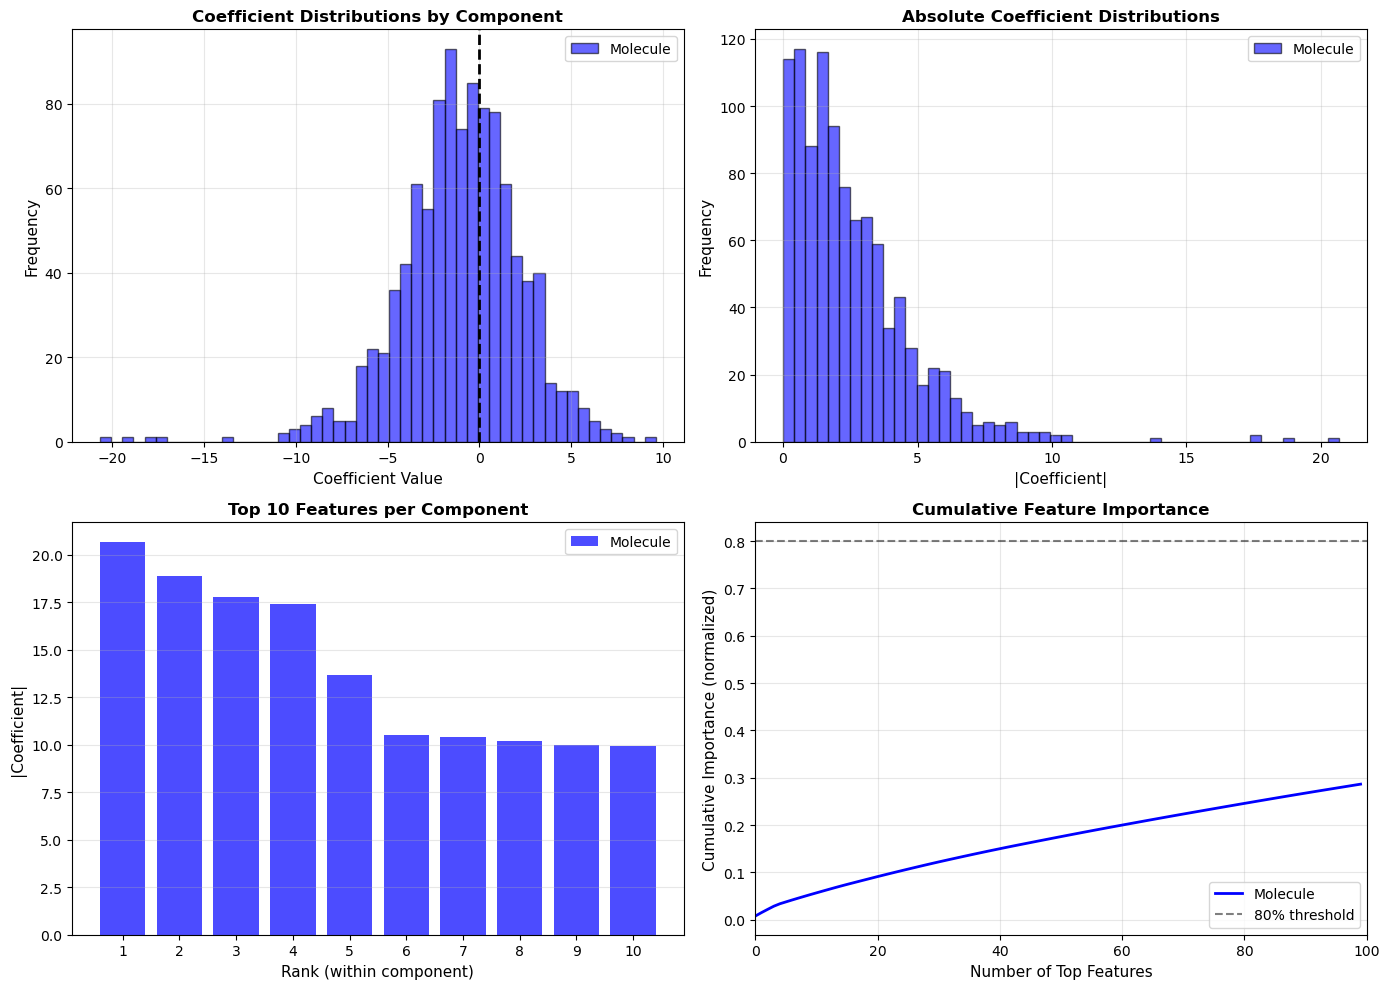


🎯 Total Importance by Component:
   Molecule       :   2623.746 (100.0%)

PART 3: STRUCTURAL FEATURE VISUALIZATION

Detected SMILES columns: ['SMILES']

Regenerating fingerprints with bit information...
(This may take a moment...)
Processed 2904 reactions

VISUALIZING TOP FEATURES BY COMPONENT

VISUALIZING MOLECULE FEATURES

🔍 Rank 1: Bit 356 (local bit 356)
   Coefficient: -20.668244
   Found in 1938 molecules


[09:47:34] DEPRECATION WARNING: please use MorganGenerator
[09:47:34] DEPRECATION WARNING: please use MorganGenerator
[09:47:34] DEPRECATION WARNING: please use MorganGenerator
[09:47:34] DEPRECATION WARNING: please use MorganGenerator
[09:47:34] DEPRECATION WARNING: please use MorganGenerator
[09:47:34] DEPRECATION WARNING: please use MorganGenerator
[09:47:34] DEPRECATION WARNING: please use MorganGenerator
[09:47:34] DEPRECATION WARNING: please use MorganGenerator
[09:47:34] DEPRECATION WARNING: please use MorganGenerator
[09:47:34] DEPRECATION WARNING: please use MorganGenerator
[09:47:34] DEPRECATION WARNING: please use MorganGenerator
[09:47:34] DEPRECATION WARNING: please use MorganGenerator
[09:47:34] DEPRECATION WARNING: please use MorganGenerator
[09:47:34] DEPRECATION WARNING: please use MorganGenerator
[09:47:34] DEPRECATION WARNING: please use MorganGenerator
[09:47:34] DEPRECATION WARNING: please use MorganGenerator
[09:47:34] DEPRECATION WARNING: please use MorganGenerat

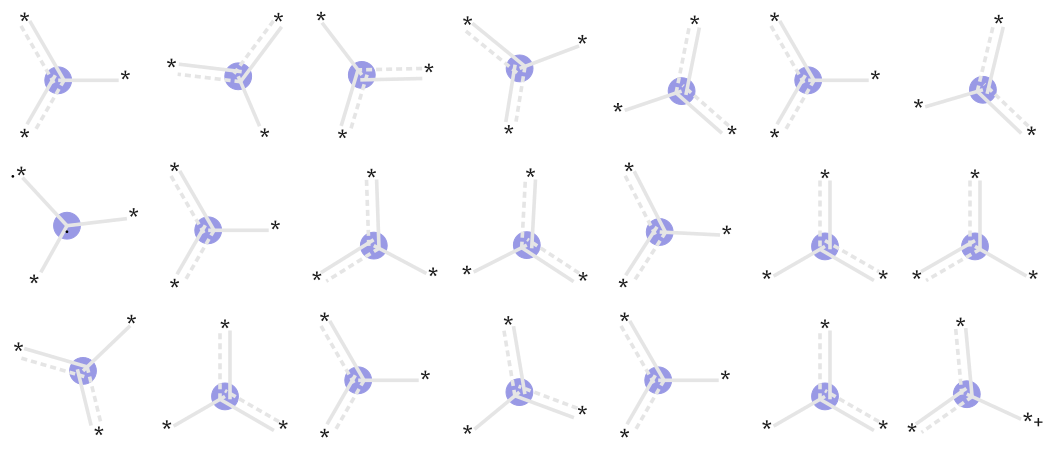


🔍 Rank 2: Bit 97 (local bit 97)
   Coefficient: -18.887547
   Found in 37 molecules


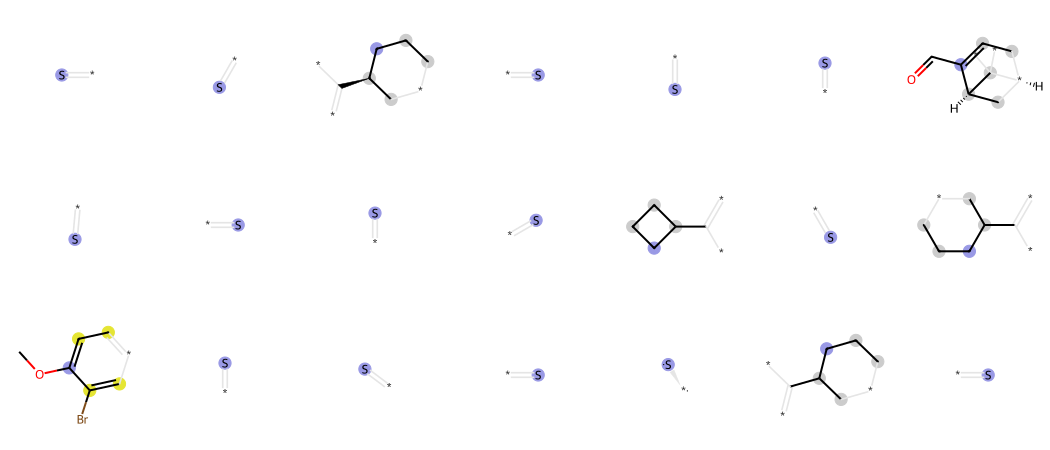


🔍 Rank 3: Bit 661 (local bit 661)
   Coefficient: -17.774614
   Found in 88 molecules


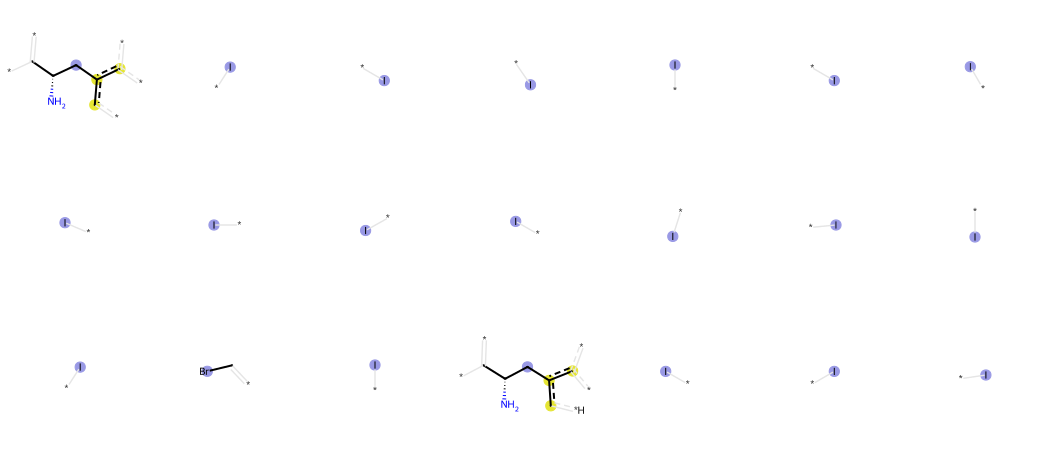


🔍 Rank 4: Bit 116 (local bit 116)
   Coefficient: -17.389383
   Found in 66 molecules


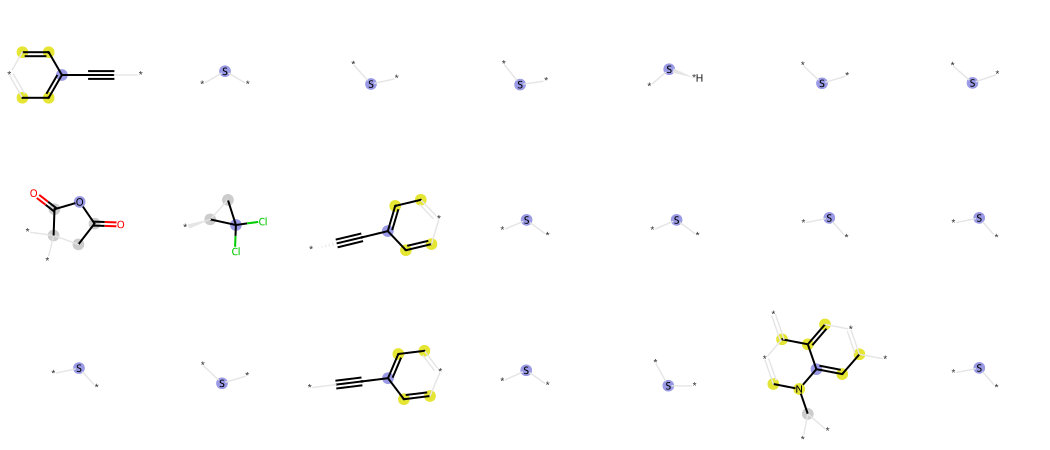


🔍 Rank 5: Bit 849 (local bit 849)
   Coefficient: -13.666192
   Found in 1865 molecules


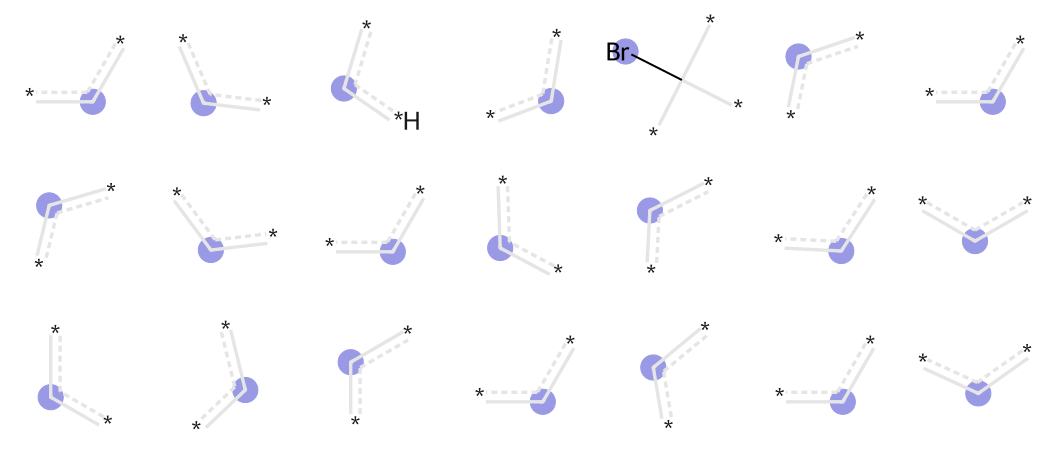


ANALYSIS COMPLETE


In [51]:
# ============================================================================
# Optional Project: Model Interpretation for Stereoselectivity Prediction
# ============================================================================

print("=" * 70)
print("MODEL INTERPRETATION: STEREOSELECTIVITY PREDICTION")
print("=" * 70)
print("\nThis analysis will help us understand which structural features")
print("drive stereoselectivity predictions in the Denmark reaction.\n")

# ============================================================================
# Part 1: Extract Feature Importances
# ============================================================================

print("=" * 70)
print("PART 1: FEATURE IMPORTANCE EXTRACTION")
print("=" * 70)

# First, let's check what columns are available
print("\nAvailable columns in DataFrame:")
print(df.columns.tolist())

# Identify the target variable (common names for stereoselectivity data)
possible_target_names = ['Output', 'ee', 'er', 'dr', 'ddG', 'ΔΔG', 'dG', 'selectivity', 'y']
target_col = None

for col_name in possible_target_names:
    if col_name in df.columns:
        target_col = col_name
        break

# If not found, use the last numeric column
if target_col is None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) > 0:
        target_col = numeric_cols[-1]
        print(f"\n⚠️  Using '{target_col}' as target variable (last numeric column)")
    else:
        raise ValueError("Could not identify target variable. Please specify manually.")
else:
    print(f"\n✓ Using '{target_col}' as target variable")

# Use the identified target variable
y_denmark = df[target_col]

# Check the feature matrix dimensions
print(f"\nFeature matrix shape: {X.shape}")
n_features = X.shape[1]

# Determine the structure based on feature count
if n_features == 3072:
    # Standard 3-component concatenation (1024 bits each)
    bits_per_component = 1024
    component_names = ['Catalyst', 'Imine', 'Thiol']
    print(f"Detected 3-component reaction fingerprint (1024 bits each)")
elif n_features == 2048:
    # 2-component reaction
    bits_per_component = 1024
    component_names = ['Reactant 1', 'Reactant 2']
    print(f"Detected 2-component reaction fingerprint (1024 bits each)")
elif n_features == 1024:
    # Single molecule
    bits_per_component = 1024
    component_names = ['Molecule']
    print(f"Detected single molecule fingerprint (1024 bits)")
else:
    # Custom split - assume equal division
    n_components = max(1, n_features // 1024)
    bits_per_component = n_features // n_components
    component_names = [f'Component {i+1}' for i in range(n_components)]
    print(f"Detected {n_components} components ({bits_per_component} bits each)")

# Train a fresh BRR model on the full dataset
print("\nTraining Bayesian Ridge Regression model...")
br_denmark = BayesianRidge()
br_denmark.fit(X, y_denmark)

print(f"Model trained on {X.shape[0]} reactions")
print(f"Feature vector length: {X.shape[1]} bits")
for i, name in enumerate(component_names):
    start = i * bits_per_component
    end = min(start + bits_per_component, n_features)
    print(f"  - {name}: bits {start}-{end-1}")

# Extract coefficients (feature importances)
coefficients = br_denmark.coef_

# Find top important features
n_top = min(30, n_features)  # Don't request more features than exist
top_indices = np.argsort(np.abs(coefficients))[::-1][:n_top]

print(f"\n🔍 Top {n_top} Most Important Features:")
print(f"{'Rank':<6} {'Bit':<8} {'Component':<15} {'Coefficient':<15} {'|Coefficient|':<15}")
print("-" * 75)

for rank, idx in enumerate(top_indices, 1):
    # Determine which component this bit belongs to
    component_idx = min(idx // bits_per_component, len(component_names) - 1)
    component = component_names[component_idx]
    local_bit = idx - (component_idx * bits_per_component)
    
    coef = coefficients[idx]
    abs_coef = np.abs(coef)
    
    print(f"{rank:<6} {idx:<8} {component:<15} {coef:+.6f}      {abs_coef:.6f}")

# ============================================================================
# Part 2: Component-Level Analysis
# ============================================================================

print("\n" + "=" * 70)
print("PART 2: PER-COMPONENT IMPORTANCE ANALYSIS")
print("=" * 70)

# Split coefficients by component
component_coefs = {}
for i, name in enumerate(component_names):
    start = i * bits_per_component
    end = min(start + bits_per_component, n_features)
    component_coefs[name] = coefficients[start:end]

# Compute statistics for each component
print("\n📊 Component Statistics:")
print(f"{'Component':<15} {'Mean |Coef|':<15} {'Max |Coef|':<15} {'Std |Coef|':<15} {'Non-zero':<12}")
print("-" * 75)

for name, coefs in component_coefs.items():
    if len(coefs) == 0:
        continue
    mean_abs = np.mean(np.abs(coefs))
    max_abs = np.max(np.abs(coefs))
    std_abs = np.std(np.abs(coefs))
    non_zero = np.sum(np.abs(coefs) > 1e-6)
    
    print(f"{name:<15} {mean_abs:<15.6f} {max_abs:<15.6f} {std_abs:<15.6f} {non_zero:<12}")

# Visualize coefficient distributions by component
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Coefficient distributions
ax1 = axes[0, 0]
colors = ['blue', 'green', 'red', 'orange', 'purple']
for i, (name, coefs) in enumerate(component_coefs.items()):
    if len(coefs) > 0:
        ax1.hist(coefs, bins=50, alpha=0.6, label=name, 
                color=colors[i % len(colors)], edgecolor='black')
ax1.set_xlabel('Coefficient Value', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Coefficient Distributions by Component', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.axvline(0, color='black', linestyle='--', linewidth=2)

# Plot 2: Absolute coefficient distributions
ax2 = axes[0, 1]
for i, (name, coefs) in enumerate(component_coefs.items()):
    if len(coefs) > 0:
        ax2.hist(np.abs(coefs), bins=50, alpha=0.6, label=name, 
                color=colors[i % len(colors)], edgecolor='black')
ax2.set_xlabel('|Coefficient|', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Absolute Coefficient Distributions', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Top features by component
ax3 = axes[1, 0]
top_n_per_component = 10
x_pos = np.arange(top_n_per_component)
width = 0.8 / len(component_names)

for i, (name, coefs) in enumerate(component_coefs.items()):
    if len(coefs) == 0:
        continue
    top_indices_comp = np.argsort(np.abs(coefs))[::-1][:top_n_per_component]
    offset = (i - len(component_names)/2 + 0.5) * width
    ax3.bar(x_pos + offset, np.abs(coefs[top_indices_comp]), width, 
            label=name, color=colors[i % len(colors)], alpha=0.7)

ax3.set_xlabel('Rank (within component)', fontsize=11)
ax3.set_ylabel('|Coefficient|', fontsize=11)
ax3.set_title(f'Top {top_n_per_component} Features per Component', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(range(1, top_n_per_component + 1))
ax3.legend()
ax3.grid(alpha=0.3, axis='y')

# Plot 4: Cumulative importance
ax4 = axes[1, 1]
for i, (name, coefs) in enumerate(component_coefs.items()):
    if len(coefs) == 0:
        continue
    sorted_coefs = np.sort(np.abs(coefs))[::-1]
    cumsum = np.cumsum(sorted_coefs) / np.sum(sorted_coefs)
    n_plot = min(100, len(cumsum))
    ax4.plot(cumsum[:n_plot], label=name, color=colors[i % len(colors)], linewidth=2)

ax4.axhline(0.8, color='black', linestyle='--', alpha=0.5, label='80% threshold')
ax4.set_xlabel('Number of Top Features', fontsize=11)
ax4.set_ylabel('Cumulative Importance (normalized)', fontsize=11)
ax4.set_title('Cumulative Feature Importance', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)
ax4.set_xlim([0, min(100, n_features)])

plt.tight_layout()
plt.show()

# Determine which component dominates
total_importance = {}
for name, coefs in component_coefs.items():
    if len(coefs) > 0:
        total_importance[name] = np.sum(np.abs(coefs))

print("\n🎯 Total Importance by Component:")
total = sum(total_importance.values())
for name, importance in sorted(total_importance.items(), key=lambda x: x[1], reverse=True):
    percentage = (importance / total) * 100
    print(f"   {name:<15}: {importance:>10.3f} ({percentage:>5.1f}%)")

# ============================================================================
# Part 3: Visualize Important Structural Features
# ============================================================================

print("\n" + "=" * 70)
print("PART 3: STRUCTURAL FEATURE VISUALIZATION")
print("=" * 70)

# Check if we have the necessary SMILES columns
smiles_columns = [col for col in df.columns if 'smiles' in col.lower() or 
                  col in ['Catalyst', 'Imine', 'Thiol', 'Reactant', 'Product']]

print(f"\nDetected SMILES columns: {smiles_columns}")

if len(smiles_columns) >= len(component_names):
    print("\nRegenerating fingerprints with bit information...")
    print("(This may take a moment...)")
    
    # Store molecules and bit info for each component
    component_mols = {name: [] for name in component_names}
    component_bit_infos = {name: [] for name in component_names}
    
    for i, row in df.iterrows():
        for j, (comp_name, smiles_col) in enumerate(zip(component_names, smiles_columns[:len(component_names)])):
            mol = Chem.MolFromSmiles(row[smiles_col])
            bi = {}
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=bits_per_component, bitInfo=bi)
            component_mols[comp_name].append(mol)
            component_bit_infos[comp_name].append(bi)
    
    print(f"Processed {len(df)} reactions")
    
    # Function to visualize bits for a component
    def visualize_component_bits(mols, bit_infos, bit_indices, component_name, n_examples=21):
        """Visualize important bits for a specific component"""
        print(f"\n{'='*70}")
        print(f"VISUALIZING {component_name.upper()} FEATURES")
        print(f"{'='*70}")
        
        # Get component index
        comp_idx = component_names.index(component_name)
        
        for rank, bit_idx in enumerate(bit_indices[:5], 1):  # Top 5 bits
            coef = coefficients[bit_idx]
            
            # Get local bit index
            local_bit = bit_idx - (comp_idx * bits_per_component)
            
            print(f"\n🔍 Rank {rank}: Bit {bit_idx} (local bit {local_bit})")
            print(f"   Coefficient: {coef:+.6f}")
            
            # Find molecules containing this bit
            tpls = [(mol, local_bit, bi) for mol, bi in zip(mols, bit_infos) if local_bit in bi]
            
            if len(tpls) == 0:
                print(f"   ⚠️  No molecules contain this bit!")
                continue
            
            print(f"   Found in {len(tpls)} molecules")
            
            # Draw examples
            n_show = min(n_examples, len(tpls))
            display(Chem.Draw.DrawMorganBits(tpls[:n_show], molsPerRow=7, useSVG=True))
    
    # Visualize top features for each component
    print("\n" + "=" * 70)
    print("VISUALIZING TOP FEATURES BY COMPONENT")
    print("=" * 70)
    
    for comp_name in component_names:
        comp_idx = component_names.index(comp_name)
        start_bit = comp_idx * bits_per_component
        end_bit = min(start_bit + bits_per_component, n_features)
        
        # Get top bits for this component
        comp_top_global = top_indices[(top_indices >= start_bit) & (top_indices < end_bit)][:5]
        
        if len(comp_top_global) > 0:
            visualize_component_bits(
                component_mols[comp_name], 
                component_bit_infos[comp_name], 
                comp_top_global, 
                comp_name
            )
else:
    print("\n⚠️  Could not find enough SMILES columns for visualization.")
    print("   Skipping structural feature visualization.")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)

---

# Part 5: Case Study 3 - Rates of Inverse Electron Demand Diels-Alder Reactions

## Introduction

Our final case study focuses on **reaction kinetics** using **quantum mechanical features**.

### The Reaction

**Inverse Electron Demand Diels-Alder (IED-DA)** reactions:
- Important in bioorthogonal chemistry
- Drug delivery systems
- Click chemistry

![IED-DA Animation](ied_da.gif)

### The Study

From [Coelho and Ravasco, JACS 2019](https://doi.org/10.1021/jacs.9b11948):
- Predict **reaction rate constants** (k₂, M⁻¹s⁻¹)
- Use **linear regression with feature selection**
- Goal: Simple, interpretable models with physical insight

### The Features

![QM Features](qm_features.jpeg)

**20 physical organic descriptors**, mostly QM-derived:
- **Sterimol parameters** (L, B₁, B₅) - steric effects
- **NBO charges** - electrostatics
- **HOMO energies** - frontier orbital theory
- **Bond lengths/angles** - geometric effects

Many can be calculated with **morfeus**!

---

## Data Preparation

The original data is in a PDF file (😱), but someone extracted it to CSV for us:

<div style="background-color: #e8f5e9; padding: 15px; border-radius: 5px; border-left: 4px solid #4caf50;">
    <strong>💡 Lesson:</strong> Always publish data in machine-readable formats! CSV, JSON, Excel are all better than PDF.
</div>

In [ ]:
df = pd.read_csv("ied_da.csv")
df.columns

### The Target Variable: Activation Energy

We're predicting **activation energy** (E_a), not raw rate constants.

**Why?** The Arrhenius equation:

$$k = A e^{-E_a/RT}$$

$$\ln k = \ln A - \frac{E_a}{RT}$$

- E_a is more **transferable** across temperatures
- E_a has clearer **physical interpretation**
- E_a relates more directly to **transition state structure**

Let's look at the distribution:

In [ ]:
y = df["activation_energy"]
y.plot.hist()

## Exploring Feature Correlations

The dataset contains 20 QM descriptors. Let's visualize their **correlation structure**:

In [ ]:
import seaborn as sns

X = df.iloc[:, 9:]
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr().abs(), cmap="coolwarm")

### Understanding Feature Correlations

**High correlations** (red blocks):
- Many features are redundant
- This is common with QM descriptors
- Example: Bond lengths often correlate with bond orders

**Why does this matter?**
- Multicollinearity makes linear regression unstable
- Feature selection can help
- Regularization (Ridge, Lasso) also helps

**Implications for our modeling:**
- We don't need all 20 features
- A simpler model with 5-10 features might work just as well
- Feature selection will improve interpretability

---

## Machine Learning with Feature Selection

### Sequential Feature Selection

We'll use **Sequential Feature Selection (SFS)** to identify the most important subset of features:

**Algorithm:**
1. Start with 0 features (forward selection)
2. For each candidate feature:
   - Add it to the current set
   - Evaluate model with cross-validation
3. Keep the feature that improves performance most
4. Repeat until we have 8 features

**Why 8 features?**
- Similar complexity to the original study
- Simpler than using all 20
- Still captures main effects

<div style="background-color: #e8f5e9; padding: 15px; border-radius: 5px; border-left: 4px solid #4caf50;">
    <strong>📝 Note:</strong> We use a different feature selection algorithm than the original study (which used Matlab), so results may differ.
</div>

Let's implement this:

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=42)

# Select 8 features.
est = make_pipeline(StandardScaler(), LinearRegression())  # Scale the data to make the model interpretation easier later.
selector = SFS(est, n_features_to_select=8, cv=10, direction="forward")
selector.fit(X_train, y_train)
print(selector.get_feature_names_out())

# Pick out only the features that were chosen
X_small = selector.transform(X)
X_small_train = selector.transform(X_train)
X_small_test = selector.transform(X_test)

# Train model on the smaller feature space
est.fit(X_small_train, y_train)
y_train_pred = est.predict(X_small_train)
y_test_pred = est.predict(X_small_test)

# Do Leave-One-Out cross validation
y_true, y_pred = [], []
for train_ix, test_ix in LeaveOneOut().split(X):
    est_ = make_pipeline(StandardScaler(), LinearRegression())
	# split data
    X_train_, X_test_ = X_small[train_ix, :], X_small[test_ix, :]
    y_train_, y_test_ = y.iloc[train_ix], y.iloc[test_ix]
	# fit model
    est_.fit(X_train_, y_train_)
	# evaluate model
    yhat = est_.predict(X_test_)
	# store
    y_true.append(y_test_.iloc[0])
    y_pred.append(yhat[0])

# Plot
fig, ax = plotter(0, 0, 0, 0, nothing=True)
plt.scatter(y_train, y_train_pred, label="Train")
plt.scatter(y_test, y_test_pred, label="Test")
#plt.scatter(y_true, y_pred, label="LOOCV")

plt.legend()
plt.xlim(5, 30)
plt.ylim(5, 30)
plt.show()
print("R2 train:", est.score(X_small_train, y_train))
print("R2 test:", est.score(X_small_test, y_test))
print("LOO Q2:", r2_score(y_true, y_pred))

## Model Performance Metrics

We report three metrics:

### 1. R² train
- Performance on training set
- High R² train → model fits training data well

### 2. R² test
- Performance on held-out test set  
- Most important for assessing generalization
- Gap between train and test → overfitting

### 3. LOO Q²
- **Leave-One-Out Cross-Validation** (LOOCV)
- Train on n-1 samples, test on 1 sample
- Repeat n times
- Maximum use of limited data
- Common in physical organic chemistry

**Q² vs R²:** Q² specifically refers to cross-validation performance, emphasizing that it's a more rigorous estimate than simple R².

---

## Which Features Were Selected?

Let's compare our selected features to those from Coelho and Ravasco:

![Important Features from Paper](important_features_small.jpeg)

**Visualizing our model's feature importances:**

In [ ]:
fig, ax = plotter(0, 0, 0, 0, nothing=True)
coefs = est.named_steps["linearregression"].coef_
plt.bar(range(len(coefs)), coefs)
_ = plt.xticks(range(len(coefs)), selector.get_feature_names_out())

### Interpreting Feature Importances

<div style="background-color: #f3e5f5; padding: 15px; border-radius: 5px; border-left: 4px solid #9c27b0;">
    <strong>🤔 Think About It:</strong>
    <ul>
        <li>Do our selected features overlap with the original study?</li>
        <li>Do the signs make chemical sense? (positive coefficient → faster reaction)</li>
        <li>Are steric features important? Electronic features?</li>
    </ul>
</div>

**Remember:** We're using a different feature selection algorithm, so exact matches aren't expected.

---

---

## Stability Analysis with Bootstrap Resampling

We've built one model and selected 8 features. But **how stable is this feature selection?**

Would we select the same features if we had a slightly different dataset?

### Introduction to Bootstrapping

**The Problem:**
- We have one dataset
- We want to assess variability in our modeling procedure
- We can't collect more data

**The Solution: Bootstrap Resampling**

Bootstrapping simulates having multiple datasets by:
1. Sampling **with replacement** from our original dataset
2. Creating a new "synthetic" dataset of the same size
3. Fitting our model to this synthetic dataset
4. Repeating many times (typically 100-1000)

**Key insight:** If we sample with replacement, we're treating our dataset as if it were the true population distribution.

**Mathematical Foundation:**
$$\hat{F} \approx F \implies \text{sampling from } \hat{F} \text{ approximates sampling from } F$$

Where F is the true distribution and F̂ is the empirical distribution.

### Why Bootstrap for Stability?

If our feature selection is **stable**:
- ✅ The same features appear in most bootstrap samples
- ✅ Model coefficients are consistent
- ✅ We can trust the selected features

If our feature selection is **unstable**:
- ❌ Different features selected in different samples
- ❌ High feature correlation causing multicollinearity
- ❌ Insufficient data for reliable selection

<div style="background-color: #fff3e0; padding: 15px; border-radius: 5px; border-left: 4px solid #ff9800;">
    <strong>⚠️ Computational Note:</strong> We'll do 5 bootstrap iterations for demonstration. In practice, 100-1000 would be more rigorous.
</div>

Let's run the stability analysis:

In [ ]:
est = make_pipeline(StandardScaler(), LinearRegression())
chosen_descriptors = []  # Collect the 8 chosen features for every round here
for i in range(5):
    print("Round", i)
    # Take bootstrap sample
    X_, y_ = resample(X, y)

    # Create train and test set from sample
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.2, shuffle=True)

    # Run feature selection
    selector = SFS(est, n_features_to_select=8, cv=10, direction="forward")

    selector.fit(X_train_, y_train_)
    print(selector.get_feature_names_out())

    # Generate train and test predictions
    X_small_train_ = selector.transform(X_train_)
    X_small_test_ = selector.transform(X_test_)
    est.fit(X_small_train_, y_train_)
    y_train_pred_ = est.predict(X_small_train_)
    y_test_pred_ = est.predict(X_small_test_)

    # Generate LOOCV predictions
    X_small_ = selector.transform(X_)
    y_true, y_pred = [], []
    for train_ix, test_ix in LeaveOneOut().split(X):
	    # split data
	    X_train__, X_test__ = X_small_[train_ix, :], X_small_[test_ix, :]
	    y_train__, y_test__ = y_.iloc[train_ix], y_.iloc[test_ix]
	    # fit model
	    est.fit(X_train__, y_train__)
	    # evaluate model
	    yhat = est.predict(X_test__)
	    # store
	    y_true.append(y_test__.iloc[0])
	    y_pred.append(yhat[0])

    # Plot
    fig, ax = plotter(0, 0, 0, 0, nothing=True)
    plt.scatter(y_train_, y_train_pred_, label="Train")
    plt.scatter(y_test_, y_test_pred_, label="Test")
    #plt.scatter(y_true, y_pred, label="LOOCV")
    plt.legend()
    plt.show()
    print("R2 train:", est.score(X_small_train_, y_train_))
    print("R2 test:", est.score(X_small_test_, y_test_))
    print("LOO Q2:", r2_score(y_true, y_pred))

    chosen_descriptors.append(selector.get_feature_names_out())

## Visualizing Feature Selection Stability

Let's count how many times each descriptor was selected across the 5 bootstrap samples:

In [ ]:
desc, counts = np.unique(chosen_descriptors, return_counts=True)
fig, ax = plotter(0, 0, 0, 0, nothing=True)
plt.bar(range(len(desc)), counts)
_ = plt.xticks(range(len(desc)), desc, rotation=45)

---

## Interpreting the Stability Analysis

<div style="background-color: #f3e5f5; padding: 15px; border-radius: 5px; border-left: 4px solid #9c27b0;">
    <strong>🤔 Critical Thinking Questions:</strong>
</div>

### 1. What conclusions can we draw from the stability analysis?
- Which features appear most consistently?
- Which features are unstable (only selected in 1-2 samples)?
- Does this affect our trust in the model?

### 2. How does this compare to Coelho and Ravasco's features?

![Important Features from Paper - Full](important_features.jpeg)

- Do their selected features appear in our stability analysis?
- If not, why might that be?

### 3. What does the feature correlation heatmap tell us?
- Go back and look at the correlation heatmap
- Are unstable features highly correlated with stable ones?
- Does this explain the instability?

### Key Lessons

**Feature selection with correlated features is inherently unstable:**
- If features A and B are highly correlated, the algorithm might pick either one
- The **choice** is unstable, but the **prediction performance** may be stable
- Both features likely carry similar information

**Implications for interpretation:**
- Don't over-interpret specific feature identities
- Focus on **groups of related features** (e.g., "steric effects" not "B₁ vs B₅")
- Consider domain knowledge alongside statistical selection

**Best practices:**
- Always assess stability of feature selection
- Report bootstrap confidence intervals
- Consider regularization methods (Elastic Net) that handle correlation better
- Use domain expertise to guide selection

---

---

# Summary and Key Takeaways

## What We Learned

### 1. Molecular Representations

**Fingerprints (Morgan/ECFP):**
- ✅ Fast to compute, sparse binary vectors
- ✅ Excellent baselines for ML
- ✅ Can be visualized and interpreted
- ❌ Fixed-length, potential bit collisions
- ❌ No explicit 3D information

**QM Descriptors:**
- ✅ Physically motivated, interpretable
- ✅ Capture electronic and geometric effects
- ❌ Computationally expensive
- ❌ Require 3D structures and conformer handling
- ❌ Manual feature engineering needed

### 2. Machine Learning Methods

| Method | Pros | Cons | Best For |
|--------|------|------|----------|
| **Linear Regression** | Fast, interpretable | Overfits easily | Quick baselines |
| **Bayesian Ridge** | Regularized, uncertainties | Slower than LR | Sparse high-dim data |
| **Random Forest** | Non-linear, robust | Doesn't extrapolate | General purpose |
| **Feature Selection + LR** | Simple, interpretable | Unstable with correlated features | Physical insight |

### 3. Evaluation Best Practices

**Always use cross-validation:**
- More reliable than single train-test split
- Reports mean ± standard error
- Enables statistical comparison

**Assess stability:**
- Bootstrap resampling
- Check feature selection consistency
- Don't over-interpret unstable features

**Multiple metrics:**
- Train vs. test performance (overfitting)
- MAE, RMSE, R² (different perspectives)
- Uncertainty quantification when available

---

## Case Studies Recap

### Case Study 1: HOMO-LUMO Gaps
- **Task:** Property prediction for 2,904 organic molecules
- **Representation:** Morgan fingerprints (1024 bits)
- **Method:** Bayesian Ridge Regression
- **Performance:** MAE ≈ 10.4 kcal/mol (0.45 eV)
- **Key Lesson:** Simple fingerprint models can be surprisingly effective

### Case Study 2: N,S-Acetal Stereoselectivity  
- **Task:** Predict enantioselectivity (ΔΔG‡) for 1,075 reactions
- **Representation:** Concatenated fingerprints (catalyst + imine + thiol)
- **Methods:** LR, BRR, RF (10 trees, 100 trees)
- **Key Lesson:** Method comparison requires statistical rigor (CV + SE)

### Case Study 3: IED-DA Reaction Rates
- **Task:** Predict activation energies using 20 QM descriptors
- **Representation:** Expert-selected QM features (Sterimol, NBO, etc.)
- **Methods:** Linear regression + sequential feature selection
- **Key Lesson:** Feature selection stability is crucial for interpretation

---

## Connecting the Three Case Studies

These case studies represent a **progression in complexity** and **complementary lessons**:

### 1. Representation Complexity
- **Case 1**: Single molecule → fingerprint
- **Case 2**: Multi-component reaction → concatenated fingerprints
- **Case 3**: QM features → expert descriptors

**Lesson:** Start simple (fingerprints), add complexity only if needed (QM).

### 2. Model Complexity
- **Case 1**: Single method exploration (BRR)
- **Case 2**: Method comparison (LR, BRR, RF)
- **Case 3**: Feature selection + stability analysis

**Lesson:** Match model complexity to problem needs and data size.

### 3. Interpretability vs. Performance
- **Case 1**: Bit visualization (moderate interpretability)
- **Case 2**: Focus on performance comparison (black box acceptable)
- **Case 3**: Feature selection for physical insight (interpretability paramount)

**Lesson:** The goal dictates the approach - discovery vs. prediction vs. understanding.

### 4. Data Regime
- **Case 1**: Large dataset (2,904) → simple methods sufficient
- **Case 2**: Medium dataset (1,075) → RF starts to help
- **Case 3**: Small dataset (~50) → sparse linear models + LOOCV

**Lesson:** Data size fundamentally constrains model choice.

---

## Looking Forward: From Classical ML to Deep Learning

The methods in this studio are **classical machine learning**. How do they relate to modern deep learning approaches?

### What Deep Learning Adds

**Graph Neural Networks (GNNs):**
- Learn fingerprint-like features automatically
- Handle variable-sized molecules naturally
- Can incorporate 3D geometry
- But require more data and compute

**Transformers:**
- SMILES-based models (like ChemBERTa)
- Pre-training on large unlabeled datasets
- Transfer learning for small datasets

**Equivariant Neural Networks:**
- Explicitly handle 3D symmetries
- Replace QM features with learned 3D representations
- State-of-the-art for properties requiring geometry

### When to Use Classical ML (This Studio)
- ✅ Small to medium datasets (<10,000)
- ✅ Need interpretability
- ✅ Limited compute resources
- ✅ Baseline for benchmarking deep learning

### When to Use Deep Learning (Future Studios)
- ✅ Large datasets (>10,000)
- ✅ Complex relationships
- ✅ Multiple related tasks (transfer learning)
- ✅ State-of-the-art performance needed

**The best practitioners use both!** Start with classical ML to understand your problem, then scale to deep learning if needed.

---

## Further Reading and Resources

### Papers from This Studio

1. **Glorius et al., Chem 2020** - Fingerprints for property and reactivity prediction
   - [DOI: 10.1016/j.chempr.2020.02.017](https://doi.org/10.1016/j.chempr.2020.02.017)
   - Excellent overview of fingerprint methods

2. **Coelho & Ravasco, JACS 2019** - Linear models for reaction kinetics
   - [DOI: 10.1021/jacs.9b11948](https://doi.org/10.1021/jacs.9b11948)
   - Physical organic chemistry meets ML

3. **Denmark et al., JACS 2011** - Original N,S-acetal chemistry
   - [DOI: 10.1021/ja203005j](https://doi.org/10.1021/ja203005j)

### Key Methodology Papers

4. **Rogers & Hahn, 2010** - Extended-Connectivity Fingerprints
   - [DOI: 10.1021/ci100050t](https://doi.org/10.1021/ci100050t)
   - The original Morgan fingerprint paper

5. **Raschka, 2018** - Model evaluation and selection
   - [Blog series](https://sebastianraschka.com/blog/2018/model-evaluation-selection-part4.html)
   - Statistical comparison of ML methods

### Software Documentation

- **RDKit**: [https://www.rdkit.org/docs/](https://www.rdkit.org/docs/)
- **morfeus**: [https://digital-chemistry-laboratory.github.io/morfeus/](https://digital-chemistry-laboratory.github.io/morfeus/)
- **scikit-learn**: [https://scikit-learn.org/](https://scikit-learn.org/)

---

## Acknowledgments

This studio is based on the original Digital Molecular Design Studio (09-860) materials from March 2022.

**Special thanks to:**
- The Glorius group for sharing their excellent datasets
- The developers of RDKit, morfeus, and scikit-learn
- The broader molecular ML community

---

<div style="background-color: #e1f5fe; padding: 20px; border-radius: 5px; text-align: center;">
    <h3>Congratulations on completing Studio 7!</h3>
    <p>You now have practical experience with fingerprints, QM features, and classical ML methods for molecular property prediction.</p>
    <p><strong>Next:</strong> We'll build on these foundations with graph neural networks and modern deep learning architectures.</p>
</div>